# Longitudinal RSA Analysis: VOTC Resection Study

## Hypothesis
Bilateral visual categories (Object, House) show greater representational reorganization than unilateral categories (Face, Word) in OTC patients, because bilateral representations are **collaborative** (not redundant) across hemispheres—losing one hemisphere forces compensation.

## Contrast Scheme Justification

### Liu Distinctiveness (Selectivity Change)
- Measures how **selective** a region is for its preferred category
- Uses contrasts that **define** category selectivity (following Liu et al.):
  - FFA: Face > Object (cope 1)
  - VWFA: Word > Scramble (cope 12) — cannot use Word > Face because face signal dominates VWFA's neighborhood
  - PPA: House > Object (cope 2)
  - LOC: Object > Scramble (cope 3)
- Question: "How correlated is preferred with non-preferred?" — about ROI's functional **identity**

### RSA Measures (Geometry Preservation, MDS Shift)
- Measures representational **structure** — how categories relate to each other
- Requires comparing patterns across all four categories simultaneously
- **Must use same baseline** for fair RDM comparison
- All Category > Scramble (copes 10, 12, 3, 11):
  - Consistent reference point
  - Each pattern reflects category response above low-level visual baseline
  - RDM comparisons are apples-to-apples

**Key distinction:** Selectivity is about a region's *identity*; RSA is about representational *structure*.

## Methodological Note: ROI Definition and Pattern Extraction

### Circularity Consideration

In this analysis, ROIs are defined using contrast maps from each session, and patterns are subsequently extracted from the same data used to define those ROIs. This approach introduces a degree of circularity, as the ROI boundaries are not independent of the data being analyzed.

We adopt this methodology for several reasons:

1. **Precedent in the literature**: This approach is standard in studies of category-selective reorganization following cortical resection. Ayzenberg et al. (2023) used suprathreshold voxels (p < 0.01, uncorrected) within anatomical masks and extracted patterns from the same data, explicitly noting that "a lax threshold [was used] because a relatively limited amount of data was collected for each participant." Similarly, Liu et al. (2025) employed peak-voxel sphere approaches for RSA without cross-validation between ROI definition and pattern extraction.

2. **Equal impact across groups**: Critically, any inflation of effect sizes due to circularity affects all participant groups (OTC, nonOTC, and control) equally. Because our primary hypothesis concerns *group differences* in the bilateral vs. unilateral contrast, circularity does not introduce systematic bias favoring our predictions.

3. **Alternative approaches are prohibitively noisy**: We explored leave-one-run-out (LORO) cross-validation, where ROIs were defined on N-1 runs and patterns extracted from the held-out run. This approach yielded geometry preservation values near zero (mean = 0.18) with weak correlation to standard estimates (r = 0.15), suggesting that single-run pattern estimates contain insufficient signal for reliable RSA. The dramatic reduction in effect size likely reflects measurement noise rather than a more accurate estimate of true representational stability.

4. **Anatomical constraints reduce arbitrary circularity**: ROIs are constrained to fall within predefined anatomical search masks for each category (e.g., fusiform for faces, parahippocampal for houses). This ensures that functional peaks reflect category-selective responses in expected cortical locations rather than arbitrary noise-driven activations.

### Interpretation

Results should be interpreted as reflecting *relative* differences between groups and category types rather than absolute estimates of representational change. The key finding—that bilateral categories show greater reorganization than unilateral categories specifically in OTC patients—is robust to the circularity concern because the methodological approach is identical across all comparisons.

**References**:
- Ayzenberg, V., et al. (2023). *Developmental Cognitive Neuroscience*, 64, 101323.
- Liu, T.T., et al. (2025). *Communications Biology*, 8, 1200.

## Cell 1: Setup & Configuration

In [7]:
import numpy as np
import nibabel as nib
from pathlib import Path
import pandas as pd
from scipy.ndimage import label, center_of_mass
from scipy.stats import pearsonr, ttest_ind, ttest_rel
from scipy.linalg import orthogonal_procrustes
import warnings
warnings.filterwarnings('ignore')

# === PATHS ===
BASE_DIR = Path("/user_data/csimmon2/long_pt")
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
OUTPUT_DIR = Path('/user_data/csimmon2/git_repos/long_pt/B_analyses')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# === SUBJECT INFO ===
df = pd.read_csv(CSV_FILE)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}
EXCLUDE_SUBJECTS = ['sub-025', 'sub-027', 'sub-045', 'sub-072']

# === CATEGORIES ===
CATEGORIES = ['face', 'word', 'object', 'house']
BILATERAL = ['object', 'house']
UNILATERAL = ['face', 'word']

# === CONTRAST SCHEMES ===

# For Liu Distinctiveness (Selectivity Change)
# Uses ROI-defining contrasts per Liu et al.
COPE_MAP_LIU = {
    'face': (1, 1),    # Face > Object
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (2, 1)    # House > Object
}

# For RSA measures (Geometry, MDS, Drift)
# Consistent baseline across all categories
COPE_MAP_SCRAMBLE = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

print("✓ Configuration loaded")
print(f"  Excluding: {EXCLUDE_SUBJECTS}")
print(f"  Liu Distinctiveness: COPE_MAP_LIU")
print(f"  RSA Measures: COPE_MAP_SCRAMBLE")

✓ Configuration loaded
  Excluding: ['sub-025', 'sub-027', 'sub-045', 'sub-072']
  Liu Distinctiveness: COPE_MAP_LIU
  RSA Measures: COPE_MAP_SCRAMBLE


## Cell 2: Load Subjects

In [8]:
def load_subjects():
    """Load all subjects from CSV, excluding problematic ones"""
    subjects = {}
    
    for _, row in df.iterrows():
        subject_id = row['sub']
        
        if subject_id in EXCLUDE_SUBJECTS:
            continue
            
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted(
            [d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], 
            key=int
        )
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        
        if len(sessions) < 2:
            continue
        
        hemi = 'l' if row.get('intact_hemi', 'left') == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemi,
            'group': row['group'],
            'patient': row['patient'] == 1,
            'surgery_side': row.get('SurgerySide', 'na'),
            'sex': row.get('sex', 'na'),
            'age_1': row.get('age_1', np.nan),
            'age_2': row.get('age_2', np.nan)
        }
    
    return subjects

SUBJECTS = load_subjects()

print(f"✓ Loaded {len(SUBJECTS)} subjects (after exclusions)")
for group in ['OTC', 'nonOTC', 'control']:
    n = sum(1 for s in SUBJECTS.values() if s['group'] == group)
    print(f"  {group}: {n}")

✓ Loaded 20 subjects (after exclusions)
  OTC: 6
  nonOTC: 7
  control: 7


## Cell 3: Helper Functions

In [9]:
def create_sphere(center_coord, affine, brain_shape, radius=6):
    """Create spherical mask around coordinate"""
    grid = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    world = nib.affines.apply_affine(affine, grid)
    distances = np.linalg.norm(world - center_coord, axis=1)
    
    mask = np.zeros(brain_shape, dtype=bool)
    within = grid[distances <= radius]
    for c in within:
        mask[c[0], c[1], c[2]] = True
    
    return mask


def filter_to_intact_hemisphere(df_results):
    """Filter results to intact hemisphere for patients, keep both for controls"""
    filtered = []
    for _, row in df_results.iterrows():
        sid = row['subject']
        info = SUBJECTS[sid]
        if info['group'] == 'control':
            filtered.append(row)
        elif row['hemi'] == info['hemi']:
            filtered.append(row)
    return pd.DataFrame(filtered)


print("✓ Helper functions defined")

✓ Helper functions defined


## Cell 4: ROI Extraction Function

In [14]:
def extract_rois(cope_map, percentile=80, min_voxels=20):
    """Extract ROIs using top-percentile dynamic threshold (floor z=1.64)"""
    
    all_rois = {}
    
    for sid, info in SUBJECTS.items():
        first_ses = info['sessions'][0]
        roi_dir = BASE_DIR / sid / f'ses-{first_ses}' / 'ROIs'
        
        if not roi_dir.exists():
            continue
        
        all_rois[sid] = {}
        
        # For controls, extract both hemispheres
        hemis = ['l', 'r'] if info['group'] == 'control' else [info['hemi']]
        
        for hemi in hemis:
            for category in CATEGORIES:
                cope_num, mult = cope_map[category]
                
                # Load search mask
                mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
                if not mask_file.exists():
                    continue
                
                try:
                    mask_img = nib.load(mask_file)
                    search_mask = mask_img.get_fdata() > 0
                    affine = mask_img.affine
                except:
                    continue
                
                roi_key = f'{hemi}_{category}'
                all_rois[sid][roi_key] = {}
                
                for session in info['sessions']:
                    feat_dir = BASE_DIR / sid / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                    z_name = 'zstat1.nii.gz' if session == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        continue
                    
                    try:
                        z_data = nib.load(cope_file).get_fdata() * mult
                        
                        # Dynamic threshold: top percentile with floor
                        pos_voxels = z_data[search_mask & (z_data > 0)]
                        if len(pos_voxels) < min_voxels:
                            continue
                        
                        dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                        suprathresh = (z_data > dynamic_thresh) & search_mask
                        
                        if suprathresh.sum() < min_voxels:
                            continue
                        
                        labeled, n_clusters = label(suprathresh)
                        if n_clusters == 0:
                            continue
                        
                        # Largest cluster
                        sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
                        best_idx = np.argmax(sizes) + 1
                        roi_mask = (labeled == best_idx)
                        
                        if roi_mask.sum() < min_voxels:
                            continue
                        
                        # Extract ROI info
                        peak_idx = np.unravel_index(np.argmax(z_data * roi_mask), z_data.shape)
                        peak_coord = nib.affines.apply_affine(affine, peak_idx)
                        centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
                        
                        all_rois[sid][roi_key][session] = {
                            'mask': roi_mask,
                            'n_voxels': int(roi_mask.sum()),
                            'peak_z': float(z_data[peak_idx]),
                            'peak_coord': peak_coord,
                            'centroid': centroid,
                            'affine': affine,
                            'threshold': dynamic_thresh,
                            'shape': z_data.shape 
                        }
                    except:
                        continue
    
    return all_rois

print("✓ ROI extraction function defined (top-20% dynamic threshold)")

✓ ROI extraction function defined (top-20% dynamic threshold)


## Cell 5: Liu Distinctiveness (Selectivity Change)

In [1]:
def compute_selectivity_change(rois, pattern_cope_map):
    """
    Selectivity Change (Liu Distinctiveness):
    - Correlation of preferred category with non-preferred categories
    - Change from T1 to T2 (absolute difference)
    """
    results = []
    
    for sid, roi_data in rois.items():
        info = SUBJECTS[sid]
        first_ses = info['sessions'][0]
        
        for roi_key, sessions_data in roi_data.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            ref_data = sessions_data[sessions[0]]
            affine = ref_data['affine']
            shape = ref_data['shape']
            
            distinctiveness = {}
            for ses in [sessions[0], sessions[-1]]:
                if ses not in sessions_data:
                    continue
                
                centroid = sessions_data[ses]['centroid']
                sphere = create_sphere(centroid, affine, shape, radius=6)
                
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = {}
                valid = True
                for cat in CATEGORIES:
                    cope_num, mult = pattern_cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns[cat] = pattern
                
                if valid and len(patterns) == 4:
                    pref_pattern = patterns[category]
                    nonpref_corrs = []
                    for other_cat in CATEGORIES:
                        if other_cat != category:
                            r, _ = pearsonr(pref_pattern, patterns[other_cat])
                            nonpref_corrs.append(np.arctanh(np.clip(r, -0.999, 0.999)))
                    
                    distinctiveness[ses] = np.mean(nonpref_corrs)
            
            if len(distinctiveness) == 2:
                change = abs(distinctiveness[sessions[-1]] - distinctiveness[sessions[0]])
                results.append({
                    'subject': sid,
                    'code': info['code'],
                    'group': info['group'],
                    'hemi': hemi,
                    'category': category,
                    'selectivity_change': change
                })
    
    return pd.DataFrame(results)

print("✓ Selectivity change function defined")

✓ Selectivity change function defined


## Cell 6: RSA Measures (Geometry Preservation, MDS Shift)

In [16]:
def compute_geometry_preservation(rois, pattern_cope_map, radius=6):
    """
    Geometry Preservation: RDM stability across sessions
    - Extract patterns from sphere at each session's centroid
    - Correlate T1 and T2 RDMs
    - Higher = more stable; lower in bilateral = MORE reorganization
    """
    results = []
    
    for sid, roi_data in rois.items():
        info = SUBJECTS[sid]
        first_ses = info['sessions'][0]
        
        for roi_key, sessions_data in roi_data.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            ref_data = sessions_data[sessions[0]]
            affine = ref_data['affine']
            shape = ref_data['shape']
            
            rdms = {}
            for ses in [sessions[0], sessions[-1]]:
                if ses not in sessions_data:
                    continue
                
                centroid = sessions_data[ses]['centroid']
                sphere = create_sphere(centroid, affine, shape, radius)
                
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                for cat in CATEGORIES:
                    cope_num, mult = pattern_cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if valid and len(patterns) == 4:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
            
            if len(rdms) == 2:
                triu = np.triu_indices(4, k=1)
                r, _ = pearsonr(rdms[sessions[0]][triu], rdms[sessions[-1]][triu])
                
                results.append({
                    'subject': sid,
                    'code': info['code'],
                    'group': info['group'],
                    'hemi': hemi,
                    'category': category,
                    'geometry_preservation': r
                })
    
    return pd.DataFrame(results)


def compute_mds_shift(rois, pattern_cope_map, radius=6):
    """
    MDS Shift: Procrustes-aligned embedding distance
    - MDS embed RDMs to 2D
    - Align with Procrustes
    - Measure movement of each category
    """
    def mds_2d(rdm):
        n = rdm.shape[0]
        H = np.eye(n) - np.ones((n, n)) / n
        B = -0.5 * H @ (rdm ** 2) @ H
        eigvals, eigvecs = np.linalg.eigh(B)
        idx = np.argsort(eigvals)[::-1]
        coords = eigvecs[:, idx[:2]] * np.sqrt(np.maximum(eigvals[idx[:2]], 0))
        return coords
    
    results = []
    
    for sid, roi_data in rois.items():
        info = SUBJECTS[sid]
        first_ses = info['sessions'][0]
        
        for roi_key, sessions_data in roi_data.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            ref_data = sessions_data[sessions[0]]
            affine = ref_data['affine']
            shape = ref_data['shape']
            
            rdms = {}
            for ses in [sessions[0], sessions[-1]]:
                if ses not in sessions_data:
                    continue
                
                centroid = sessions_data[ses]['centroid']
                sphere = create_sphere(centroid, affine, shape, radius)
                
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                for cat in CATEGORIES:
                    cope_num, mult = pattern_cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if valid and len(patterns) == 4:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
            
            if len(rdms) == 2:
                try:
                    coords_t1 = mds_2d(rdms[sessions[0]])
                    coords_t2 = mds_2d(rdms[sessions[-1]])
                    
                    R, _ = orthogonal_procrustes(coords_t1, coords_t2)
                    coords_t1_aligned = coords_t1 @ R
                    
                    for i, cat in enumerate(CATEGORIES):
                        dist = np.linalg.norm(coords_t1_aligned[i] - coords_t2[i])
                        results.append({
                            'subject': sid,
                            'code': info['code'],
                            'group': info['group'],
                            'hemi': hemi,
                            'roi_category': roi_category,
                            'measured_category': cat,
                            'mds_shift': dist
                        })
                except:
                    continue
    
    return pd.DataFrame(results)


def compute_spatial_drift(rois):
    """
    Spatial Drift: Euclidean distance between T1 and T2 peak centroids
    """
    results = []
    
    for sid, roi_data in rois.items():
        info = SUBJECTS[sid]
        
        for roi_key, sessions_data in roi_data.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            results.append({
                'subject': sid,
                'code': info['code'],
                'group': info['group'],
                'hemi': hemi,
                'category': category,
                'spatial_drift_mm': drift,
                't1_peak_z': sessions_data[sessions[0]]['peak_z']
            })
    
    return pd.DataFrame(results)

print("✓ RSA metric functions defined")

✓ RSA metric functions defined


## Cell 7: Extract ROIs and Compute All Measures

In [17]:
## Cell 7: Extract ROIs and Compute All Measures

print("="*70)
print("EXTRACTING ROIs")
print("="*70)

# Liu ROIs for Selectivity Change
print("\nExtracting Liu ROIs (for Selectivity Change)...")
rois_liu = extract_rois(COPE_MAP_LIU)
n_liu = sum(len([k for k, v in roi_data.items() if len(v) >= 2]) for roi_data in rois_liu.values())
print(f"  ✓ {len(rois_liu)} subjects, {n_liu} ROIs with 2+ sessions")

# Scramble ROIs for RSA measures
print("\nExtracting Scramble ROIs (for RSA measures)...")
rois_scramble = extract_rois(COPE_MAP_SCRAMBLE)
n_scr = sum(len([k for k, v in roi_data.items() if len(v) >= 2]) for roi_data in rois_scramble.values())
print(f"  ✓ {len(rois_scramble)} subjects, {n_scr} ROIs with 2+ sessions")

print("\n" + "="*70)
print("COMPUTING ALL MEASURES")
print("="*70)

# --- PRIMARY MEASURES (Hypothesis-relevant) ---

# Selectivity Change (using Liu ROIs and Liu patterns)
print("\nComputing Selectivity Change (Liu ROIs + Liu patterns)...")
selectivity_df = compute_selectivity_change(rois_liu, COPE_MAP_LIU)
print(f"  ✓ {len(selectivity_df)} measurements")

# Geometry Preservation (using Scramble ROIs and Scramble patterns)
print("\nComputing Geometry Preservation (Scramble ROIs + Scramble patterns)...")
geometry_df = compute_geometry_preservation(rois_scramble, COPE_MAP_SCRAMBLE)
print(f"  ✓ {len(geometry_df)} measurements")

# MDS Shift (using Scramble ROIs and Scramble patterns)
print("\nComputing MDS Shift (Scramble ROIs + Scramble patterns)...")
mds_df = compute_mds_shift(rois_scramble, COPE_MAP_SCRAMBLE)
print(f"  ✓ {len(mds_df)} measurements")

# Spatial Drift (using Scramble ROIs)
print("\nComputing Spatial Drift (Scramble ROIs)...")
drift_df = compute_spatial_drift(rois_scramble)
print(f"  ✓ {len(drift_df)} measurements")

# --- SANITY CHECK MEASURES (Ayzenberg et al., 2023) ---

def compute_ayzenberg_measures(rois, cope_map, threshold_z=2.3):
    """
    Compute mean activation and sum selectivity at T1 and T2.
    
    Following Ayzenberg et al. (2023):
    - Mean activation: mean of zstat values within suprathreshold voxels
    - Sum selectivity: sum of zstat values within suprathreshold voxels,
      normalized by total voxels in anatomical search mask, × 1000
    """
    results = []
    
    for sid, roi_data in rois.items():
        info = SUBJECTS[sid]
        first_ses = info['sessions'][0]
        
        for roi_key, sessions_data in roi_data.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            # Load anatomical search mask for normalization
            roi_file = BASE_DIR / sid / f'ses-{first_ses}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
            if not roi_file.exists():
                continue
            
            try:
                mask_img = nib.load(roi_file)
                search_mask = mask_img.get_fdata() > 0
                total_mask_voxels = np.sum(search_mask)
                
                if total_mask_voxels == 0:
                    continue
            except:
                continue
            
            # Compute for T1 and T2
            session_results = {}
            for ses_label, ses in [('T1', sessions[0]), ('T2', sessions[-1])]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                zstat_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not zstat_file.exists():
                    continue
                
                try:
                    zstat_data = nib.load(zstat_file).get_fdata() * mult
                    suprathresh_mask = (zstat_data > threshold_z) & search_mask
                    vox_resp = zstat_data[suprathresh_mask]
                    
                    if len(vox_resp) > 0:
                        session_results[ses_label] = {
                            'mean_activation': float(np.mean(vox_resp)),
                            'sum_selectivity': (float(np.sum(vox_resp)) / total_mask_voxels) * 1000,
                            'n_voxels': len(vox_resp)
                        }
                    else:
                        session_results[ses_label] = {
                            'mean_activation': 0.0,
                            'sum_selectivity': 0.0,
                            'n_voxels': 0
                        }
                except:
                    continue
            
            # Only include if we have both sessions
            if 'T1' in session_results and 'T2' in session_results:
                results.append({
                    'subject': sid,
                    'code': info['code'],
                    'group': info['group'],
                    'hemi': hemi,
                    'category': category,
                    'mean_activation_T1': session_results['T1']['mean_activation'],
                    'mean_activation_T2': session_results['T2']['mean_activation'],
                    'sum_selectivity_T1': session_results['T1']['sum_selectivity'],
                    'sum_selectivity_T2': session_results['T2']['sum_selectivity'],
                    'n_voxels_T1': session_results['T1']['n_voxels'],
                    'n_voxels_T2': session_results['T2']['n_voxels'],
                    'mean_activation_change': abs(session_results['T2']['mean_activation'] - session_results['T1']['mean_activation']),
                    'sum_selectivity_change': abs(session_results['T2']['sum_selectivity'] - session_results['T1']['sum_selectivity']),
                    'n_voxels_change': session_results['T2']['n_voxels'] - session_results['T1']['n_voxels']
                })
    
    return pd.DataFrame(results)

print("\nComputing Ayzenberg Measures (sanity check)...")
ayzenberg_df = compute_ayzenberg_measures(rois_liu, COPE_MAP_LIU)
print(f"  ✓ {len(ayzenberg_df)} measurements")

print("\n" + "="*70)
print("ALL MEASURES COMPUTED")
print("="*70)

EXTRACTING ROIs

Extracting Liu ROIs (for Selectivity Change)...
  ✓ 20 subjects, 108 ROIs with 2+ sessions

Extracting Scramble ROIs (for RSA measures)...
  ✓ 20 subjects, 108 ROIs with 2+ sessions

COMPUTING ALL MEASURES

Computing Selectivity Change (Liu ROIs + Liu patterns)...
  ✓ 108 measurements

Computing Geometry Preservation (Scramble ROIs + Scramble patterns)...
  ✓ 108 measurements

Computing MDS Shift (Scramble ROIs + Scramble patterns)...
  ✓ 432 measurements

Computing Spatial Drift (Scramble ROIs)...
  ✓ 108 measurements

Computing Ayzenberg Measures (sanity check)...
  ✓ 108 measurements

ALL MEASURES COMPUTED


## Cell 8: Statistical Tests - Bilateral vs Unilateral

In [18]:
## Cell 8: Statistical Tests - Bilateral vs Unilateral

def cohens_d(g1, g2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(g1), len(g2)
    var1, var2 = g1.var(), g2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (g1.mean() - g2.mean()) / pooled_std if pooled_std > 0 else 0

def fdr_correction(p_values, alpha=0.05):
    """Benjamini-Hochberg FDR correction"""
    p_array = np.array(p_values)
    n = len(p_array)
    sorted_idx = np.argsort(p_array)
    sorted_p = p_array[sorted_idx]
    
    critical = (np.arange(1, n+1) / n) * alpha
    below = sorted_p <= critical
    
    if not below.any():
        return p_array, np.zeros(n, dtype=bool)
    
    max_idx = np.max(np.where(below)[0])
    threshold = sorted_p[max_idx]
    significant = p_array <= threshold
    
    return p_array, significant

def test_bilateral_effect(df, metric_col, metric_name, higher_means_more_change=True):
    """Test if bilateral differs from unilateral within each group"""
    
    print(f"\n{'='*70}")
    print(f"{metric_name}")
    if higher_means_more_change:
        print("(Higher = more change; expect bilateral > unilateral in OTC)")
    else:
        print("(Lower = more change; expect bilateral < unilateral in OTC)")
    print("="*70)
    
    filtered_df = filter_to_intact_hemisphere(df)
    filtered_df = filtered_df.copy()
    filtered_df['cat_type'] = filtered_df['category'].apply(
        lambda x: 'Bilateral' if x in BILATERAL else 'Unilateral'
    )
    
    print(f"\n{'Group':<10} {'Bilateral':<16} {'Unilateral':<16} {'Diff':<8} {'d':<8} {'t':<8} {'p':<10}")
    print("-"*80)
    
    results = []
    p_values = []
    
    for group in ['OTC', 'nonOTC', 'control']:
        gd = filtered_df[filtered_df['group'] == group]
        bil = gd[gd['cat_type'] == 'Bilateral'][metric_col].dropna()
        uni = gd[gd['cat_type'] == 'Unilateral'][metric_col].dropna()
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            d = cohens_d(bil, uni)
            diff = bil.mean() - uni.mean()
            p_values.append(p)
            
            results.append({
                'group': group,
                'metric': metric_name,
                'bilateral_mean': bil.mean(),
                'bilateral_std': bil.std(),
                'unilateral_mean': uni.mean(),
                'unilateral_std': uni.std(),
                'difference': diff,
                'cohens_d': d,
                't': t,
                'p': p
            })
    
    # FDR correction across the 3 group tests
    _, sig_fdr = fdr_correction(p_values)
    
    for i, res in enumerate(results):
        res['p_fdr_sig'] = sig_fdr[i]
        if sig_fdr[i]:
            sig_mark = '** (FDR)'
        elif res['p'] < 0.05:
            sig_mark = '*'
        else:
            sig_mark = ''
        
        print(f"{res['group']:<10} {res['bilateral_mean']:.3f}±{res['bilateral_std']:.3f}    "
              f"{res['unilateral_mean']:.3f}±{res['unilateral_std']:.3f}    "
              f"{res['difference']:+.3f}   {res['cohens_d']:+.2f}    {res['t']:.2f}    {res['p']:.4f} {sig_mark}")
    
    return pd.DataFrame(results)


print("\n" + "#"*70)
print("BILATERAL vs UNILATERAL STATISTICAL TESTS")
print("#"*70)

all_stats = []

# Primary measures
selectivity_stats = test_bilateral_effect(
    selectivity_df, 'selectivity_change', 'SELECTIVITY CHANGE', 
    higher_means_more_change=True
)
all_stats.append(selectivity_stats)

geometry_stats = test_bilateral_effect(
    geometry_df, 'geometry_preservation', 'GEOMETRY PRESERVATION',
    higher_means_more_change=False
)
all_stats.append(geometry_stats)

drift_stats = test_bilateral_effect(
    drift_df, 'spatial_drift_mm', 'SPATIAL DRIFT',
    higher_means_more_change=True
)
all_stats.append(drift_stats)

# MDS shift - aggregate by subject/category first
mds_agg = mds_df.groupby(['subject', 'group', 'hemi', 'measured_category'])['mds_shift'].mean().reset_index()
mds_agg = mds_agg.rename(columns={'measured_category': 'category'})
mds_stats = test_bilateral_effect(
    mds_agg, 'mds_shift', 'MDS SHIFT',
    higher_means_more_change=True
)
all_stats.append(mds_stats)

# Ayzenberg measures (sanity checks)
print("\n" + "#"*70)
print("AYZENBERG MEASURES (Sanity Checks)")
print("#"*70)

mean_act_stats = test_bilateral_effect(
    ayzenberg_df, 'mean_activation_change', 'MEAN ACTIVATION CHANGE',
    higher_means_more_change=True
)
all_stats.append(mean_act_stats)

sum_sel_stats = test_bilateral_effect(
    ayzenberg_df, 'sum_selectivity_change', 'SUM SELECTIVITY CHANGE',
    higher_means_more_change=True
)
all_stats.append(sum_sel_stats)

# Global FDR correction
print("\n" + "="*70)
print("GLOBAL FDR CORRECTION (across all 18 tests)")
print("="*70)

all_results = pd.concat(all_stats)
all_p = all_results['p'].values
_, all_sig = fdr_correction(all_p)
all_results['global_fdr_sig'] = all_sig

print(f"\n{'Metric':<30} {'Group':<10} {'p':<10} {'FDR sig':<10}")
print("-"*60)
for _, row in all_results.iterrows():
    print(f"{row['metric']:<30} {row['group']:<10} {row['p']:.4f}    {'Yes' if row['global_fdr_sig'] else 'No'}")


######################################################################
BILATERAL vs UNILATERAL STATISTICAL TESTS
######################################################################

SELECTIVITY CHANGE
(Higher = more change; expect bilateral > unilateral in OTC)

Group      Bilateral        Unilateral       Diff     d        t        p         
--------------------------------------------------------------------------------
OTC        0.261±0.130    0.161±0.121    +0.100   +0.79    1.95    0.0645 
nonOTC     0.181±0.139    0.131±0.147    +0.050   +0.35    0.93    0.3623 
control    0.334±0.311    0.157±0.146    +0.177   +0.73    2.72    0.0088 ** (FDR)

GEOMETRY PRESERVATION
(Lower = more change; expect bilateral < unilateral in OTC)

Group      Bilateral        Unilateral       Diff     d        t        p         
--------------------------------------------------------------------------------
OTC        0.070±0.543    0.021±0.475    +0.049   +0.10    0.24    0.8155 
nonOTC     0.

## Cell 9: Bootstrap Analysis

In [19]:
## Cell 9: Bootstrap Analysis

def bootstrap_group_comparison(df, metric_col, n_boot=10000, seed=42):
    """Bootstrap test for OTC bilateral advantage vs other groups"""
    np.random.seed(seed)
    
    filtered_df = filter_to_intact_hemisphere(df)
    filtered_df = filtered_df.copy()
    filtered_df['cat_type'] = filtered_df['category'].apply(
        lambda x: 'Bilateral' if x in BILATERAL else 'Unilateral'
    )
    
    # Calculate subject-level bilateral advantage (gap)
    subject_gaps = {}
    for group in ['OTC', 'nonOTC', 'control']:
        gd = filtered_df[filtered_df['group'] == group]
        gaps = []
        for sid in gd['subject'].unique():
            sd = gd[gd['subject'] == sid]
            bil = sd[sd['cat_type'] == 'Bilateral'][metric_col].mean()
            uni = sd[sd['cat_type'] == 'Unilateral'][metric_col].mean()
            if pd.notna(bil) and pd.notna(uni):
                gaps.append(bil - uni)
        subject_gaps[group] = np.array(gaps)
    
    print(f"\n  Subject-level gaps (Bilateral - Unilateral):")
    for g, gaps in subject_gaps.items():
        if len(gaps) > 0:
            print(f"    {g}: n={len(gaps)}, mean={gaps.mean():.3f}, SD={gaps.std():.3f}")
    
    results = []
    p_values = []
    
    for comp_group in ['nonOTC', 'control']:
        g1 = subject_gaps['OTC']
        g2 = subject_gaps[comp_group]
        
        if len(g1) < 2 or len(g2) < 2:
            continue
        
        observed_diff = np.mean(g1) - np.mean(g2)
        d = cohens_d(pd.Series(g1), pd.Series(g2))
        
        boot_diffs = []
        for _ in range(n_boot):
            s1 = np.random.choice(g1, size=len(g1), replace=True)
            s2 = np.random.choice(g2, size=len(g2), replace=True)
            boot_diffs.append(np.mean(s1) - np.mean(s2))
        
        boot_diffs = np.array(boot_diffs)
        ci_low = np.percentile(boot_diffs, 2.5)
        ci_high = np.percentile(boot_diffs, 97.5)
        
        # Two-tailed p-value
        if observed_diff > 0:
            p_val = 2 * np.mean(boot_diffs <= 0)
        else:
            p_val = 2 * np.mean(boot_diffs >= 0)
        p_val = min(p_val, 1.0)
        
        p_values.append(p_val)
        results.append({
            'comparison': f'OTC vs {comp_group}',
            'observed_diff': observed_diff,
            'cohens_d': d,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'p_value': p_val
        })
    
    # FDR correction within metric
    if len(p_values) > 0:
        _, sig_fdr = fdr_correction(p_values)
        for i, res in enumerate(results):
            res['fdr_sig'] = sig_fdr[i]
            sig_mark = '** (FDR)' if sig_fdr[i] else ('*' if res['p_value'] < 0.05 else '')
            print(f"\n  {res['comparison']}: diff={res['observed_diff']:.3f}, d={res['cohens_d']:.2f}, "
                  f"95%CI=[{res['ci_low']:.3f}, {res['ci_high']:.3f}], p={res['p_value']:.4f} {sig_mark}")
    
    return pd.DataFrame(results)


print("\n" + "#"*70)
print("BOOTSTRAP ANALYSIS")
print("#"*70)

all_boot_results = []

# Primary measures
print("\n" + "="*70)
print("PRIMARY MEASURES")
print("="*70)

print("\n--- SELECTIVITY CHANGE ---")
print("(Positive diff = OTC shows MORE bilateral effect than comparison group)")
boot_sel = bootstrap_group_comparison(selectivity_df, 'selectivity_change')
boot_sel['metric'] = 'Selectivity Change'
all_boot_results.append(boot_sel)

print("\n--- GEOMETRY PRESERVATION ---")
print("(Negative diff = OTC shows LESS preservation = more reorganization)")
boot_geom = bootstrap_group_comparison(geometry_df, 'geometry_preservation')
boot_geom['metric'] = 'Geometry Preservation'
all_boot_results.append(boot_geom)

print("\n--- SPATIAL DRIFT ---")
print("(Positive diff = OTC shows MORE spatial drift)")
boot_drift = bootstrap_group_comparison(drift_df, 'spatial_drift_mm')
boot_drift['metric'] = 'Spatial Drift'
all_boot_results.append(boot_drift)

print("\n--- MDS SHIFT ---")
print("(Positive diff = OTC shows MORE MDS shift)")
boot_mds = bootstrap_group_comparison(mds_agg, 'mds_shift')
boot_mds['metric'] = 'MDS Shift'
all_boot_results.append(boot_mds)

# Ayzenberg measures (sanity checks)
print("\n" + "="*70)
print("AYZENBERG MEASURES (Sanity Checks)")
print("="*70)

print("\n--- MEAN ACTIVATION CHANGE ---")
boot_mean_act = bootstrap_group_comparison(ayzenberg_df, 'mean_activation_change')
boot_mean_act['metric'] = 'Mean Activation Change'
all_boot_results.append(boot_mean_act)

print("\n--- SUM SELECTIVITY CHANGE ---")
boot_sum_sel = bootstrap_group_comparison(ayzenberg_df, 'sum_selectivity_change')
boot_sum_sel['metric'] = 'Sum Selectivity Change'
all_boot_results.append(boot_sum_sel)

# Global FDR across all bootstrap tests
print("\n" + "="*70)
print("GLOBAL FDR CORRECTION (all 12 bootstrap comparisons)")
print("="*70)

all_boot_df = pd.concat(all_boot_results, ignore_index=True)
all_boot_p = all_boot_df['p_value'].values
_, all_boot_sig = fdr_correction(all_boot_p)
all_boot_df['global_fdr_sig'] = all_boot_sig

print(f"\n{'Metric':<30} {'Comparison':<18} {'p':<10} {'Global FDR':<10}")
print("-"*70)
for _, row in all_boot_df.iterrows():
    print(f"{row['metric']:<30} {row['comparison']:<18} {row['p_value']:.4f}    {'Yes' if row['global_fdr_sig'] else 'No'}")


######################################################################
BOOTSTRAP ANALYSIS
######################################################################

PRIMARY MEASURES

--- SELECTIVITY CHANGE ---
(Positive diff = OTC shows MORE bilateral effect than comparison group)

  Subject-level gaps (Bilateral - Unilateral):
    OTC: n=6, mean=0.100, SD=0.089
    nonOTC: n=7, mean=0.050, SD=0.084
    control: n=7, mean=0.177, SD=0.152

  OTC vs nonOTC: diff=0.050, d=0.53, 95%CI=[-0.038, 0.151], p=0.3170 

  OTC vs control: diff=-0.077, d=-0.56, 95%CI=[-0.214, 0.049], p=0.2530 

--- GEOMETRY PRESERVATION ---
(Negative diff = OTC shows LESS preservation = more reorganization)

  Subject-level gaps (Bilateral - Unilateral):
    OTC: n=6, mean=0.049, SD=0.568
    nonOTC: n=7, mean=0.064, SD=0.382
    control: n=7, mean=-0.106, SD=0.449

  OTC vs nonOTC: diff=-0.015, d=-0.03, 95%CI=[-0.562, 0.504], p=0.9734 

  OTC vs control: diff=0.156, d=0.28, 95%CI=[-0.406, 0.720], p=0.5876 

--- SPATI

## Cell 10: Category-Level Results

In [20]:
## Cell 10: Category-Level Results

print("\n" + "#"*70)
print("CATEGORY-LEVEL RESULTS")
print("#"*70)

def print_category_table(df, metric_col, title):
    """Print mean values by group and category"""
    filtered = filter_to_intact_hemisphere(df)
    
    print(f"\n--- {title} ---")
    print(f"{'Group':<12} {'Face':<10} {'Word':<10} {'Object':<10} {'House':<10}")
    print("-"*55)
    
    for group in ['OTC', 'nonOTC', 'control']:
        gd = filtered[filtered['group'] == group]
        vals = []
        for cat in ['face', 'word', 'object', 'house']:
            cd = gd[gd['category'] == cat][metric_col]
            if len(cd) > 0:
                vals.append(f"{cd.mean():.2f}")
            else:
                vals.append("--")
        print(f"{group:<12} {vals[0]:<10} {vals[1]:<10} {vals[2]:<10} {vals[3]:<10}")

# Primary measures
print("\n" + "="*70)
print("PRIMARY MEASURES")
print("="*70)

print_category_table(selectivity_df, 'selectivity_change', 'SELECTIVITY CHANGE (higher = more change)')
print_category_table(geometry_df, 'geometry_preservation', 'GEOMETRY PRESERVATION (lower = more change)')
print_category_table(drift_df, 'spatial_drift_mm', 'SPATIAL DRIFT (mm)')

# MDS shift needs special handling
print("\n--- MDS SHIFT (averaged across ROI locations) ---")
mds_filtered = filter_to_intact_hemisphere(
    mds_df.rename(columns={'roi_category': 'category'})
)
mds_avg = mds_filtered.groupby(['group', 'measured_category'])['mds_shift'].mean().reset_index()

print(f"{'Group':<12} {'Face':<10} {'Word':<10} {'Object':<10} {'House':<10}")
print("-"*55)
for group in ['OTC', 'nonOTC', 'control']:
    gd = mds_avg[mds_avg['group'] == group]
    vals = []
    for cat in ['face', 'word', 'object', 'house']:
        cd = gd[gd['measured_category'] == cat]['mds_shift']
        if len(cd) > 0:
            vals.append(f"{cd.values[0]:.2f}")
        else:
            vals.append("--")
    print(f"{group:<12} {vals[0]:<10} {vals[1]:<10} {vals[2]:<10} {vals[3]:<10}")

# Ayzenberg measures (sanity checks)
print("\n" + "="*70)
print("AYZENBERG MEASURES (Sanity Checks)")
print("="*70)

print_category_table(ayzenberg_df, 'mean_activation_change', 'MEAN ACTIVATION CHANGE')
print_category_table(ayzenberg_df, 'sum_selectivity_change', 'SUM SELECTIVITY CHANGE')
print_category_table(ayzenberg_df, 'mean_activation_T1', 'MEAN ACTIVATION AT T1')
print_category_table(ayzenberg_df, 'sum_selectivity_T1', 'SUM SELECTIVITY AT T1')
print_category_table(ayzenberg_df, 'n_voxels_T1', 'N VOXELS AT T1')


######################################################################
CATEGORY-LEVEL RESULTS
######################################################################

PRIMARY MEASURES

--- SELECTIVITY CHANGE (higher = more change) ---
Group        Face       Word       Object     House     
-------------------------------------------------------
OTC          0.15       0.17       0.24       0.28      
nonOTC       0.09       0.17       0.16       0.20      
control      0.14       0.17       0.25       0.42      

--- GEOMETRY PRESERVATION (lower = more change) ---
Group        Face       Word       Object     House     
-------------------------------------------------------
OTC          0.16       -0.12      0.23       -0.09     
nonOTC       0.74       0.54       0.85       0.56      
control      0.76       0.28       0.38       0.45      

--- SPATIAL DRIFT (mm) ---
Group        Face       Word       Object     House     
-------------------------------------------------------
OTC

## Cell 11: Export Final Results

In [21]:
## Cell 11: Export Final Results

print("\n" + "#"*70)
print("EXPORTING FINAL RESULTS")
print("#"*70)

# Build comprehensive export DataFrame
export_data = []

# Filter all dataframes to intact hemisphere
selectivity_filt = filter_to_intact_hemisphere(selectivity_df)
geometry_filt = filter_to_intact_hemisphere(geometry_df)
drift_filt = filter_to_intact_hemisphere(drift_df)
ayzenberg_filt = filter_to_intact_hemisphere(ayzenberg_df)

for _, row in selectivity_filt.iterrows():
    sid = row['subject']
    info = SUBJECTS[sid]
    
    # Match geometry (from scramble ROIs)
    geom_match = geometry_filt[
        (geometry_filt['subject'] == sid) & 
        (geometry_filt['hemi'] == row['hemi']) &
        (geometry_filt['category'] == row['category'])
    ]
    
    # Match drift (from scramble ROIs)
    drift_match = drift_filt[
        (drift_filt['subject'] == sid) & 
        (drift_filt['hemi'] == row['hemi']) &
        (drift_filt['category'] == row['category'])
    ]
    
    # MDS shift (average across ROI locations for this measured category)
    mds_match = mds_df[
        (mds_df['subject'] == sid) & 
        (mds_df['hemi'] == row['hemi']) &
        (mds_df['measured_category'] == row['category'])
    ]['mds_shift'].mean()
    
    # Ayzenberg measures
    ayz_match = ayzenberg_filt[
        (ayzenberg_filt['subject'] == sid) & 
        (ayzenberg_filt['hemi'] == row['hemi']) &
        (ayzenberg_filt['category'] == row['category'])
    ]
    
    export_row = {
        # Demographics
        'Subject': row['code'],
        'Group': info['group'],
        'Surgery_Side': info['surgery_side'],
        'Intact_Hemisphere': 'left' if info['hemi'] == 'l' else 'right',
        'Sex': info['sex'],
        'nonpt_hemi': row['hemi'].upper() if info['group'] == 'control' else 'na',
        'Category': row['category'].title(),
        'Category_Type': 'Bilateral' if row['category'] in BILATERAL else 'Unilateral',
        'age_1': info['age_1'],
        'age_2': info['age_2'],
        'yr_gap': info['age_2'] - info['age_1'] if pd.notna(info['age_1']) and pd.notna(info['age_2']) else np.nan,
        
        # Primary measures
        'Selectivity_Change': row['selectivity_change'],
        'Geometry_Preservation': geom_match['geometry_preservation'].values[0] if len(geom_match) > 0 else np.nan,
        'Spatial_Drift_mm': drift_match['spatial_drift_mm'].values[0] if len(drift_match) > 0 else np.nan,
        'MDS_Shift': mds_match if pd.notna(mds_match) else np.nan,
        
        # Ayzenberg measures - change scores
        'Mean_Activation_Change': ayz_match['mean_activation_change'].values[0] if len(ayz_match) > 0 else np.nan,
        'Sum_Selectivity_Change': ayz_match['sum_selectivity_change'].values[0] if len(ayz_match) > 0 else np.nan,
        'N_Voxels_Change': ayz_match['n_voxels_change'].values[0] if len(ayz_match) > 0 else np.nan,
        
        # Ayzenberg measures - T1 values
        'Mean_Activation_T1': ayz_match['mean_activation_T1'].values[0] if len(ayz_match) > 0 else np.nan,
        'Sum_Selectivity_T1': ayz_match['sum_selectivity_T1'].values[0] if len(ayz_match) > 0 else np.nan,
        'N_Voxels_T1': ayz_match['n_voxels_T1'].values[0] if len(ayz_match) > 0 else np.nan,
        
        # Ayzenberg measures - T2 values
        'Mean_Activation_T2': ayz_match['mean_activation_T2'].values[0] if len(ayz_match) > 0 else np.nan,
        'Sum_Selectivity_T2': ayz_match['sum_selectivity_T2'].values[0] if len(ayz_match) > 0 else np.nan,
        'N_Voxels_T2': ayz_match['n_voxels_T2'].values[0] if len(ayz_match) > 0 else np.nan,
    }
    
    export_data.append(export_row)

export_df = pd.DataFrame(export_data)

# Save
output_file = OUTPUT_DIR / 'rsa_results_comprehensive.csv'
export_df.to_csv(output_file, index=False)

print(f"\n✓ Saved to: {output_file}")
print(f"  Shape: {export_df.shape}")

print(f"\nColumns ({len(export_df.columns)} total):")
print("  Demographics:", ['Subject', 'Group', 'Surgery_Side', 'Intact_Hemisphere', 'Sex', 'nonpt_hemi', 'Category', 'Category_Type', 'age_1', 'age_2', 'yr_gap'])
print("  Primary measures:", ['Selectivity_Change', 'Geometry_Preservation', 'Spatial_Drift_mm', 'MDS_Shift'])
print("  Ayzenberg measures:", ['Mean_Activation_Change', 'Sum_Selectivity_Change', 'N_Voxels_Change', 
                                 'Mean_Activation_T1', 'Sum_Selectivity_T1', 'N_Voxels_T1',
                                 'Mean_Activation_T2', 'Sum_Selectivity_T2', 'N_Voxels_T2'])

# Summary counts
print("\n" + "-"*70)
print("DATA SUMMARY")
print("-"*70)
print(f"\nSubjects per group:")
print(export_df.groupby('Group')['Subject'].nunique())
print(f"\nMeasurements per category:")
print(export_df.groupby('Category').size())
print(f"\nMeasurements per category type:")
print(export_df.groupby('Category_Type').size())


######################################################################
EXPORTING FINAL RESULTS
######################################################################

✓ Saved to: /user_data/csimmon2/git_repos/long_pt/B_analyses/rsa_results_comprehensive.csv
  Shape: (108, 24)

Columns (24 total):
  Demographics: ['Subject', 'Group', 'Surgery_Side', 'Intact_Hemisphere', 'Sex', 'nonpt_hemi', 'Category', 'Category_Type', 'age_1', 'age_2', 'yr_gap']
  Primary measures: ['Selectivity_Change', 'Geometry_Preservation', 'Spatial_Drift_mm', 'MDS_Shift']
  Ayzenberg measures: ['Mean_Activation_Change', 'Sum_Selectivity_Change', 'N_Voxels_Change', 'Mean_Activation_T1', 'Sum_Selectivity_T1', 'N_Voxels_T1', 'Mean_Activation_T2', 'Sum_Selectivity_T2', 'N_Voxels_T2']

----------------------------------------------------------------------
DATA SUMMARY
----------------------------------------------------------------------

Subjects per group:
Group
OTC        6
control    7
nonOTC     7
Name: Subject,

## Cell 12: Summary Statistics

In [22]:
## Cell 12: Summary Statistics

print("\n" + "#"*70)
print("FINAL SUMMARY STATISTICS")
print("#"*70)

# Primary measures summary
print("\n" + "="*70)
print("PRIMARY MEASURES BY GROUP AND CATEGORY TYPE")
print("="*70)

summary_primary = export_df.groupby(['Group', 'Category_Type']).agg({
    'Selectivity_Change': ['mean', 'std', 'count'],
    'Geometry_Preservation': ['mean', 'std'],
    'Spatial_Drift_mm': ['mean', 'std'],
    'MDS_Shift': ['mean', 'std']
}).round(3)
print(summary_primary)

# Ayzenberg measures summary
print("\n" + "="*70)
print("AYZENBERG MEASURES BY GROUP AND CATEGORY TYPE (Sanity Checks)")
print("="*70)

summary_ayzenberg = export_df.groupby(['Group', 'Category_Type']).agg({
    'Mean_Activation_Change': ['mean', 'std'],
    'Sum_Selectivity_Change': ['mean', 'std'],
    'Mean_Activation_T1': ['mean', 'std'],
    'Sum_Selectivity_T1': ['mean', 'std'],
    'N_Voxels_T1': ['mean', 'std']
}).round(3)
print(summary_ayzenberg)

# Key findings
print("\n" + "="*70)
print("KEY FINDINGS: OTC BILATERAL vs UNILATERAL")
print("="*70)

otc_bil = export_df[(export_df['Group'] == 'OTC') & (export_df['Category_Type'] == 'Bilateral')]
otc_uni = export_df[(export_df['Group'] == 'OTC') & (export_df['Category_Type'] == 'Unilateral')]

print("\n--- Primary Measures ---")

print(f"\nSelectivity Change:")
print(f"  Bilateral:  {otc_bil['Selectivity_Change'].mean():.3f} ± {otc_bil['Selectivity_Change'].std():.3f} (n={len(otc_bil)})")
print(f"  Unilateral: {otc_uni['Selectivity_Change'].mean():.3f} ± {otc_uni['Selectivity_Change'].std():.3f} (n={len(otc_uni)})")
t, p = ttest_ind(otc_bil['Selectivity_Change'], otc_uni['Selectivity_Change'])
print(f"  Difference: {otc_bil['Selectivity_Change'].mean() - otc_uni['Selectivity_Change'].mean():+.3f}, t={t:.2f}, p={p:.4f}")

print(f"\nGeometry Preservation:")
bil_geom = otc_bil['Geometry_Preservation'].dropna()
uni_geom = otc_uni['Geometry_Preservation'].dropna()
print(f"  Bilateral:  {bil_geom.mean():.3f} ± {bil_geom.std():.3f} (n={len(bil_geom)})")
print(f"  Unilateral: {uni_geom.mean():.3f} ± {uni_geom.std():.3f} (n={len(uni_geom)})")
t, p = ttest_ind(bil_geom, uni_geom)
print(f"  Difference: {bil_geom.mean() - uni_geom.mean():+.3f}, t={t:.2f}, p={p:.4f}")

print(f"\nSpatial Drift:")
bil_drift = otc_bil['Spatial_Drift_mm'].dropna()
uni_drift = otc_uni['Spatial_Drift_mm'].dropna()
print(f"  Bilateral:  {bil_drift.mean():.3f} ± {bil_drift.std():.3f} (n={len(bil_drift)})")
print(f"  Unilateral: {uni_drift.mean():.3f} ± {uni_drift.std():.3f} (n={len(uni_drift)})")
t, p = ttest_ind(bil_drift, uni_drift)
print(f"  Difference: {bil_drift.mean() - uni_drift.mean():+.3f}, t={t:.2f}, p={p:.4f}")

print(f"\nMDS Shift:")
bil_mds = otc_bil['MDS_Shift'].dropna()
uni_mds = otc_uni['MDS_Shift'].dropna()
print(f"  Bilateral:  {bil_mds.mean():.3f} ± {bil_mds.std():.3f} (n={len(bil_mds)})")
print(f"  Unilateral: {uni_mds.mean():.3f} ± {uni_mds.std():.3f} (n={len(uni_mds)})")
t, p = ttest_ind(bil_mds, uni_mds)
print(f"  Difference: {bil_mds.mean() - uni_mds.mean():+.3f}, t={t:.2f}, p={p:.4f}")

print("\n--- Ayzenberg Measures (Sanity Checks) ---")

print(f"\nMean Activation Change:")
bil_mac = otc_bil['Mean_Activation_Change'].dropna()
uni_mac = otc_uni['Mean_Activation_Change'].dropna()
print(f"  Bilateral:  {bil_mac.mean():.3f} ± {bil_mac.std():.3f} (n={len(bil_mac)})")
print(f"  Unilateral: {uni_mac.mean():.3f} ± {uni_mac.std():.3f} (n={len(uni_mac)})")

print(f"\nSum Selectivity Change:")
bil_ssc = otc_bil['Sum_Selectivity_Change'].dropna()
uni_ssc = otc_uni['Sum_Selectivity_Change'].dropna()
print(f"  Bilateral:  {bil_ssc.mean():.3f} ± {bil_ssc.std():.3f} (n={len(bil_ssc)})")
print(f"  Unilateral: {uni_ssc.mean():.3f} ± {uni_ssc.std():.3f} (n={len(uni_ssc)})")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


######################################################################
FINAL SUMMARY STATISTICS
######################################################################

PRIMARY MEASURES BY GROUP AND CATEGORY TYPE
                      Selectivity_Change              Geometry_Preservation  \
                                    mean    std count                  mean   
Group   Category_Type                                                         
OTC     Bilateral                  0.261  0.130    12                 0.070   
        Unilateral                 0.161  0.121    12                 0.021   
control Bilateral                  0.334  0.311    28                 0.414   
        Unilateral                 0.157  0.146    28                 0.521   
nonOTC  Bilateral                  0.181  0.139    14                 0.704   
        Unilateral                 0.131  0.147    14                 0.640   

                             Spatial_Drift_mm         MDS_Shift         
  

## Cell 13: Visualizations

GENERATING VISUALIZATIONS

SELECTIVITY CHANGE

--- Face ---


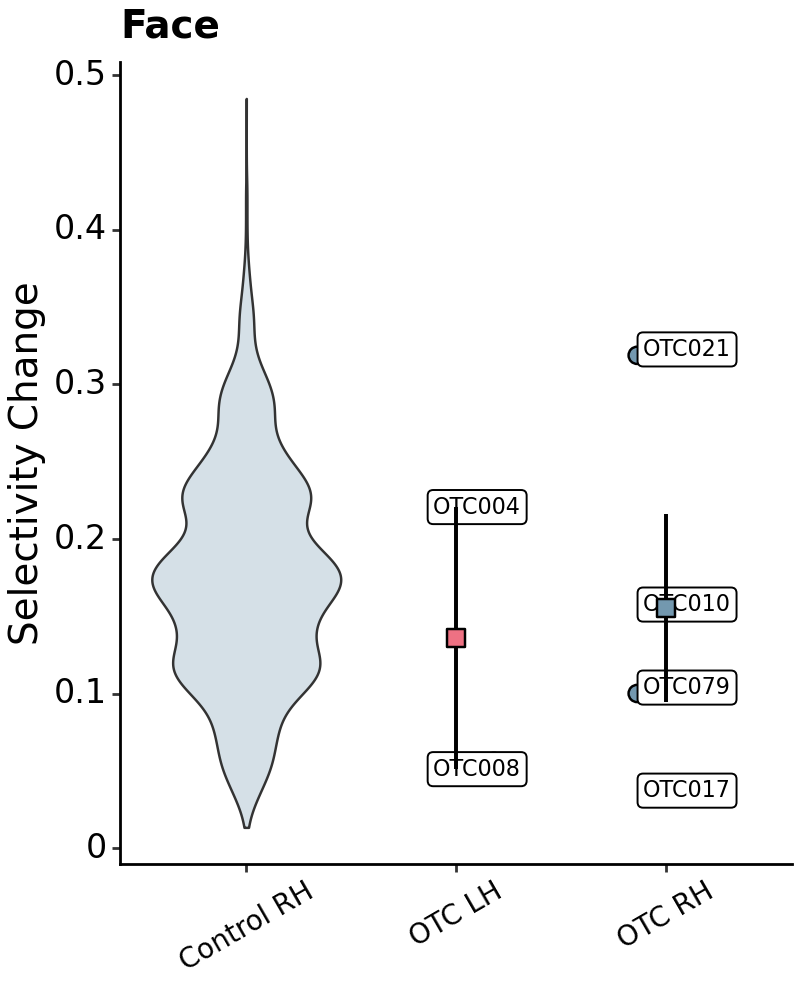



--- Word ---


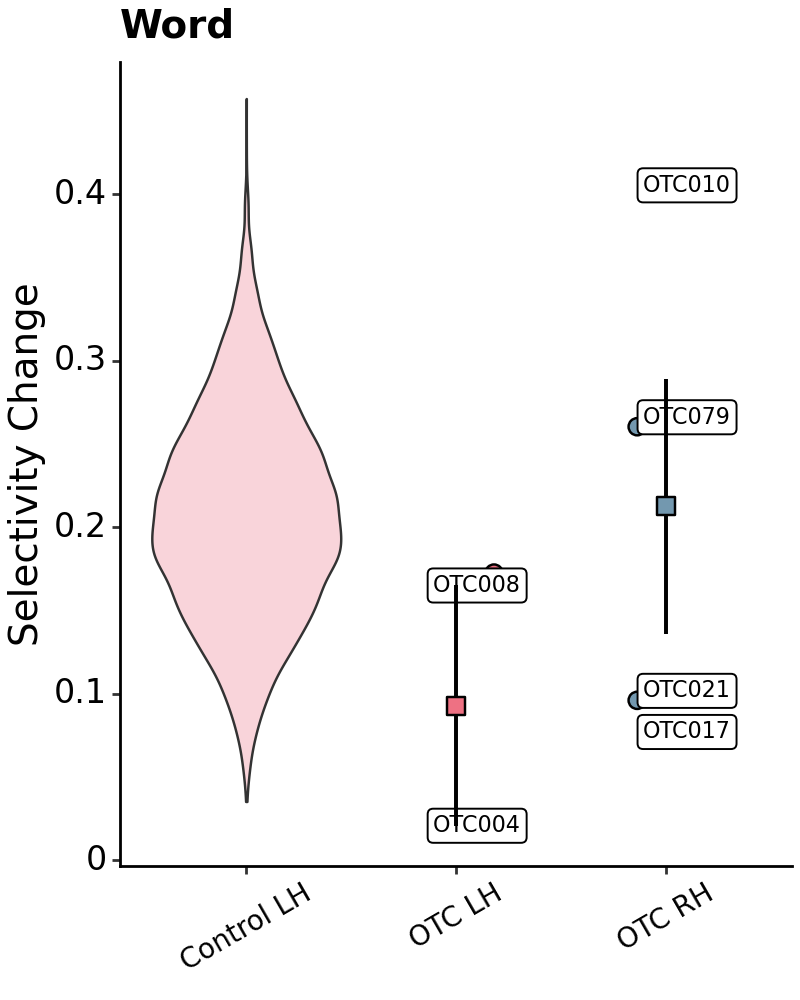



--- Object ---


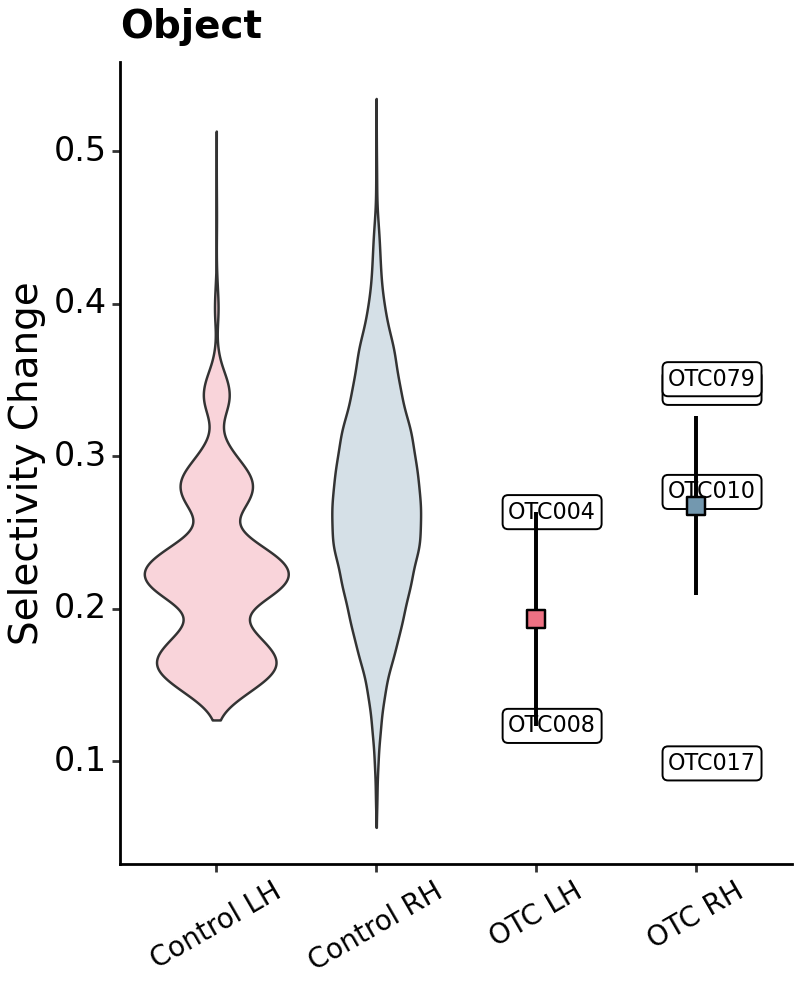



--- House ---


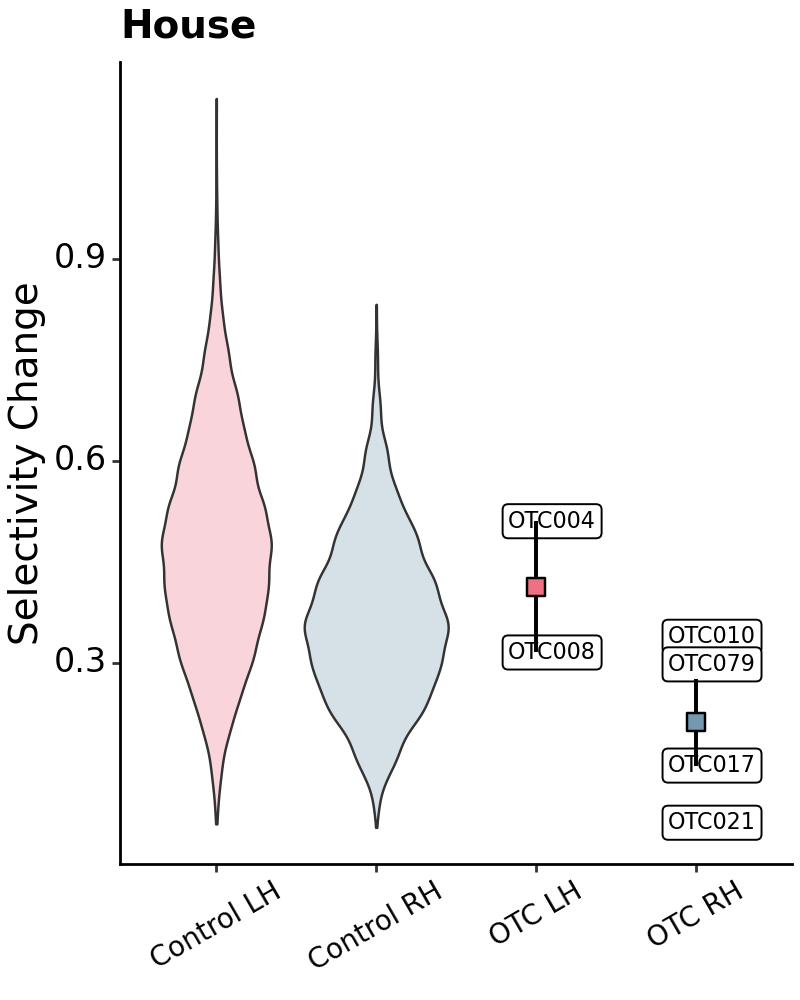



GEOMETRY PRESERVATION

--- Face ---


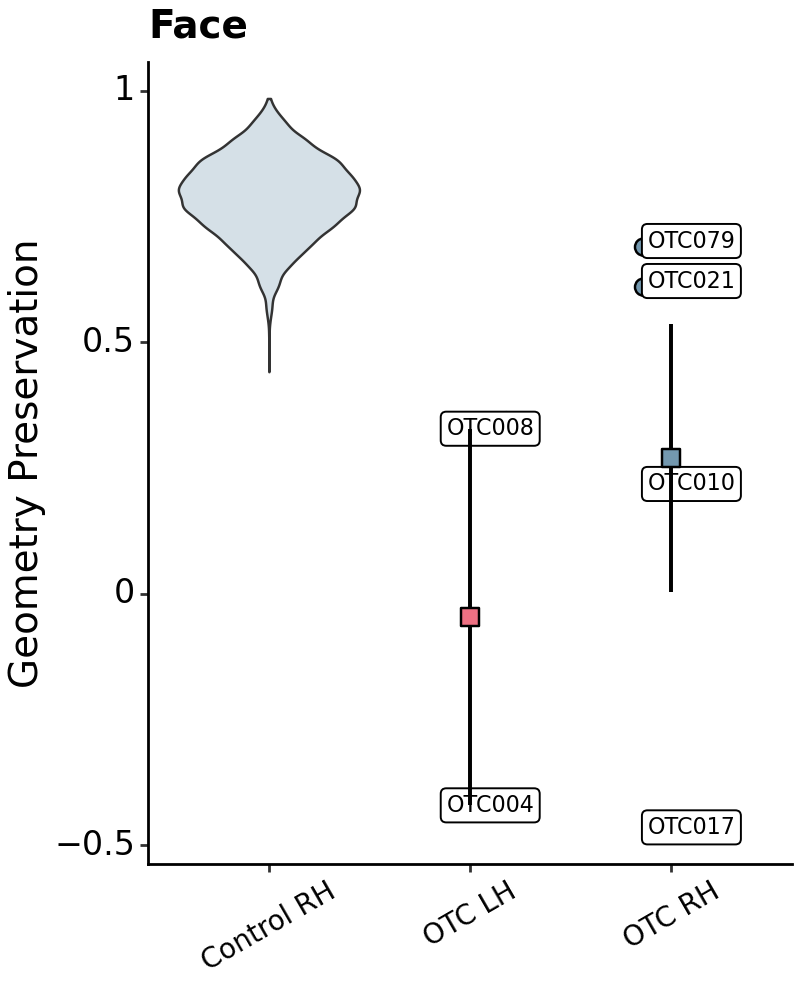



--- Word ---


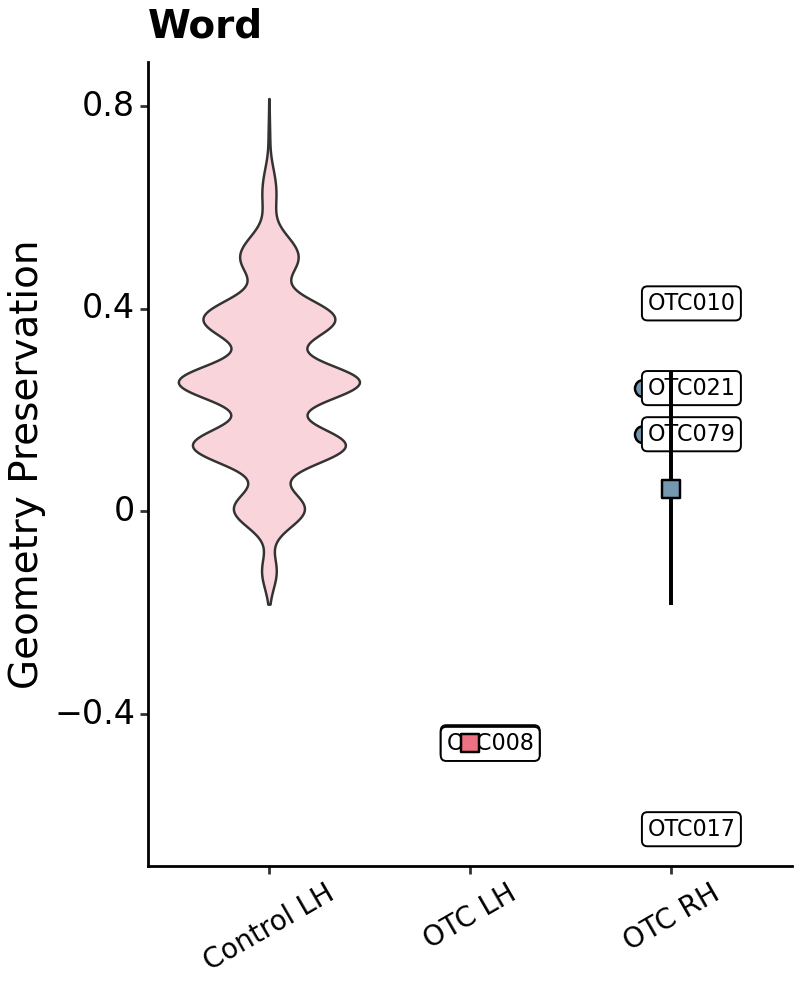



--- Object ---


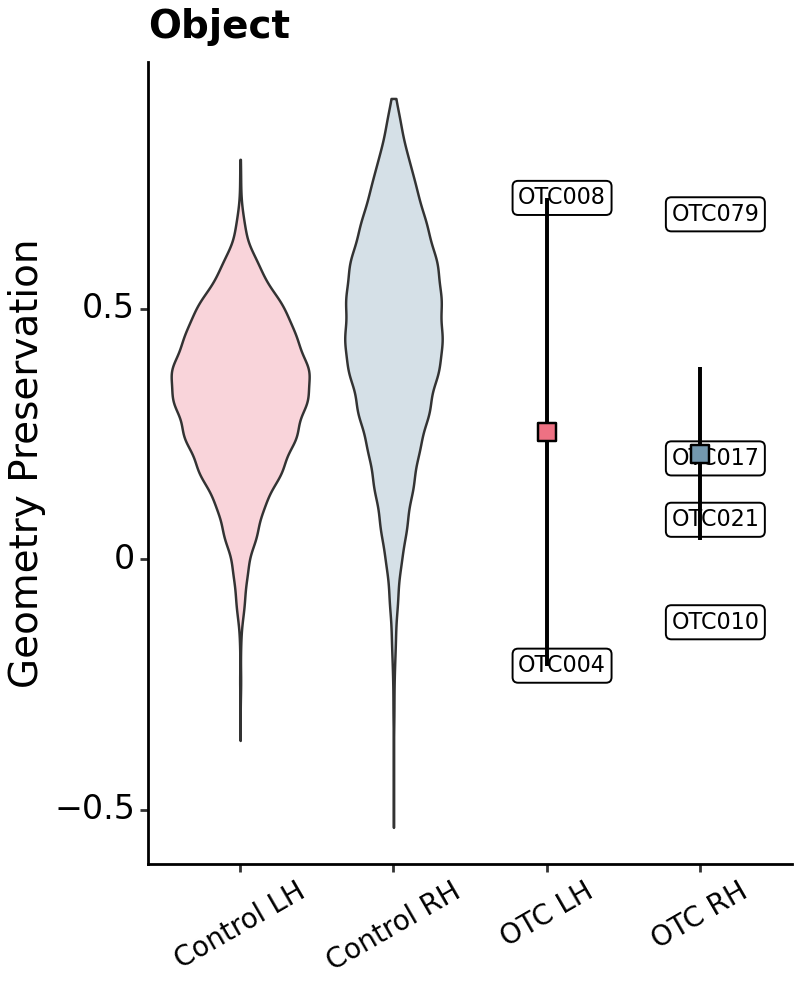



--- House ---


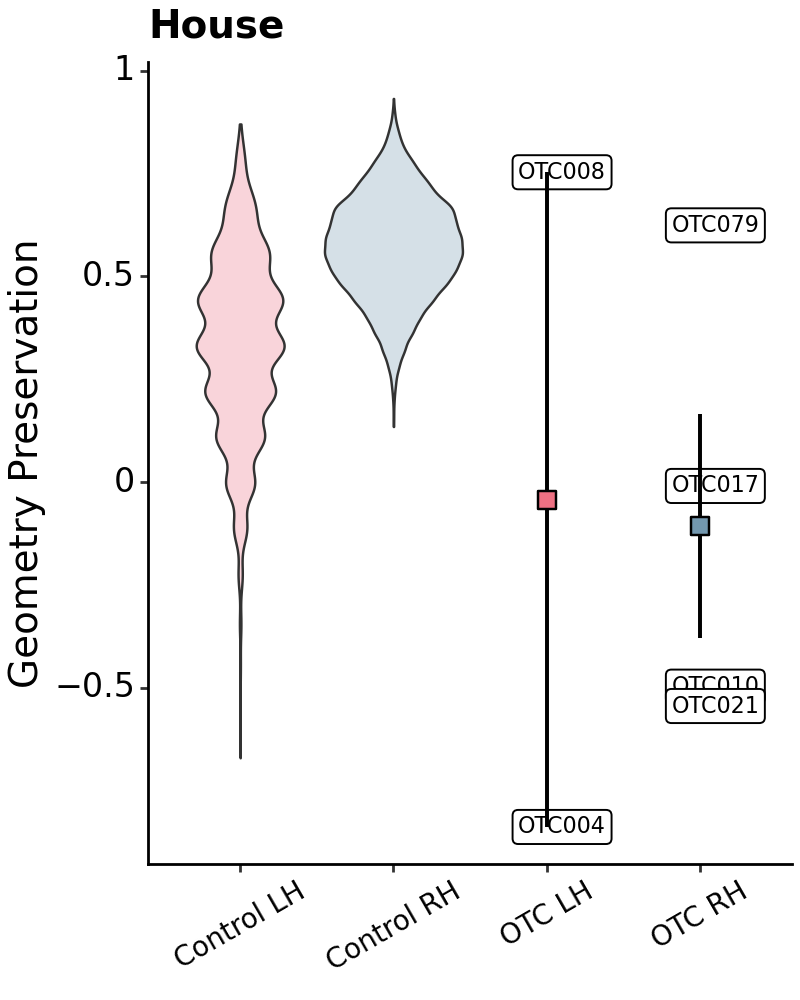



SPATIAL DRIFT (MM)

--- Face ---


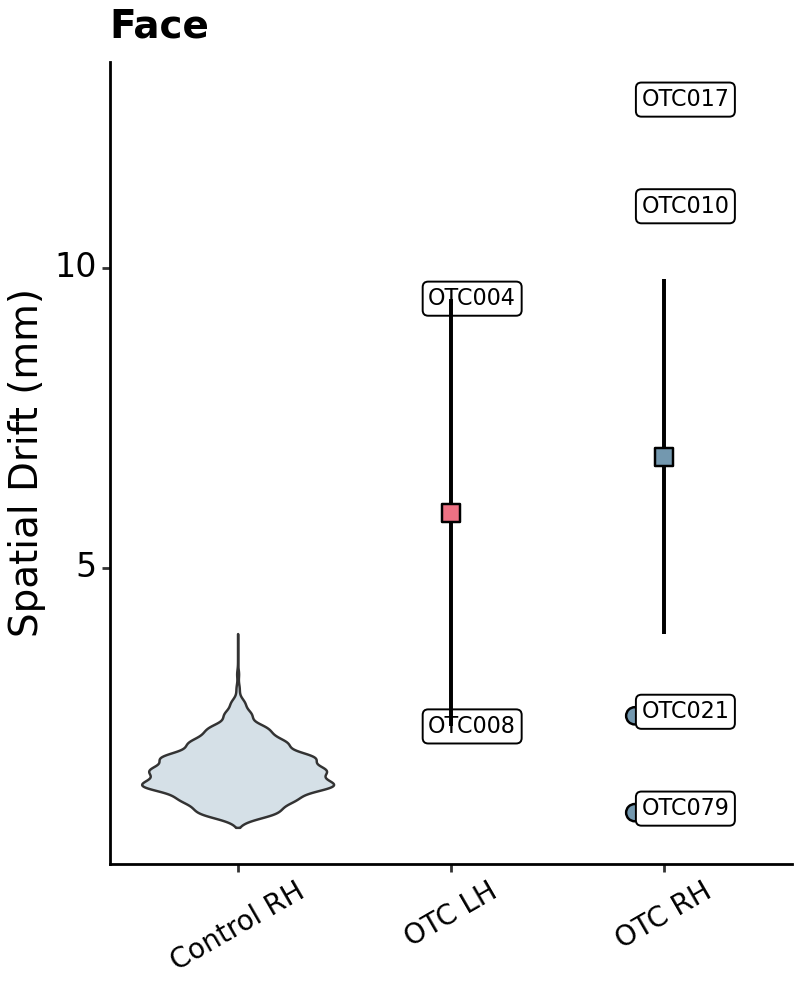



--- Word ---


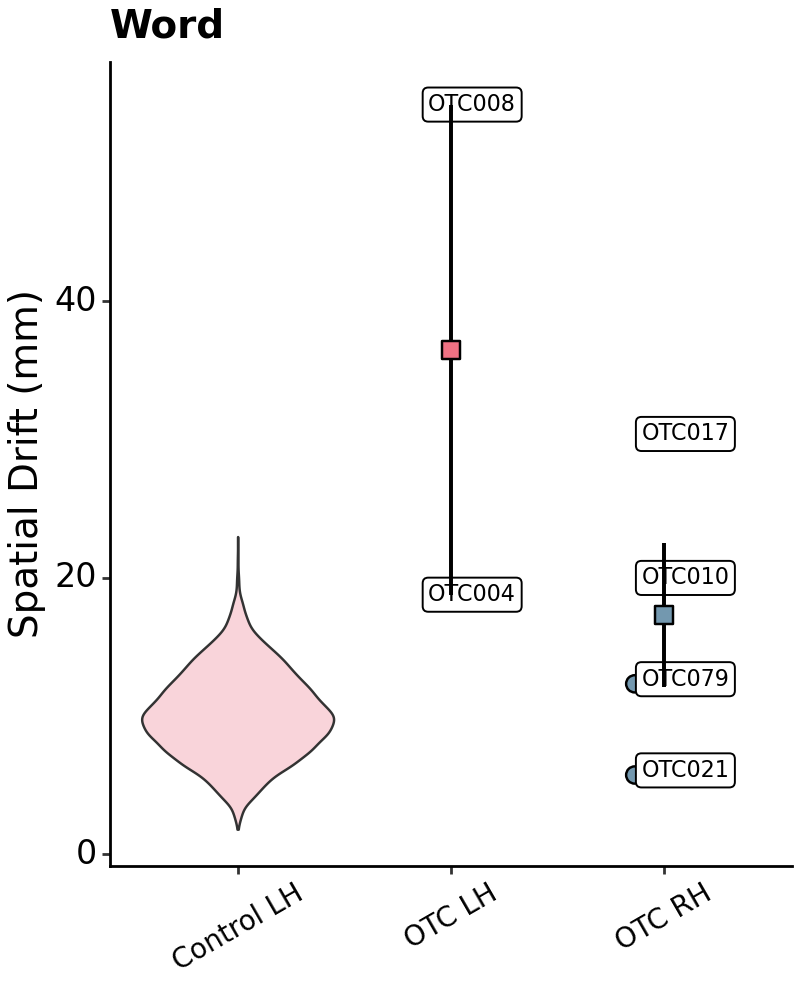



--- Object ---


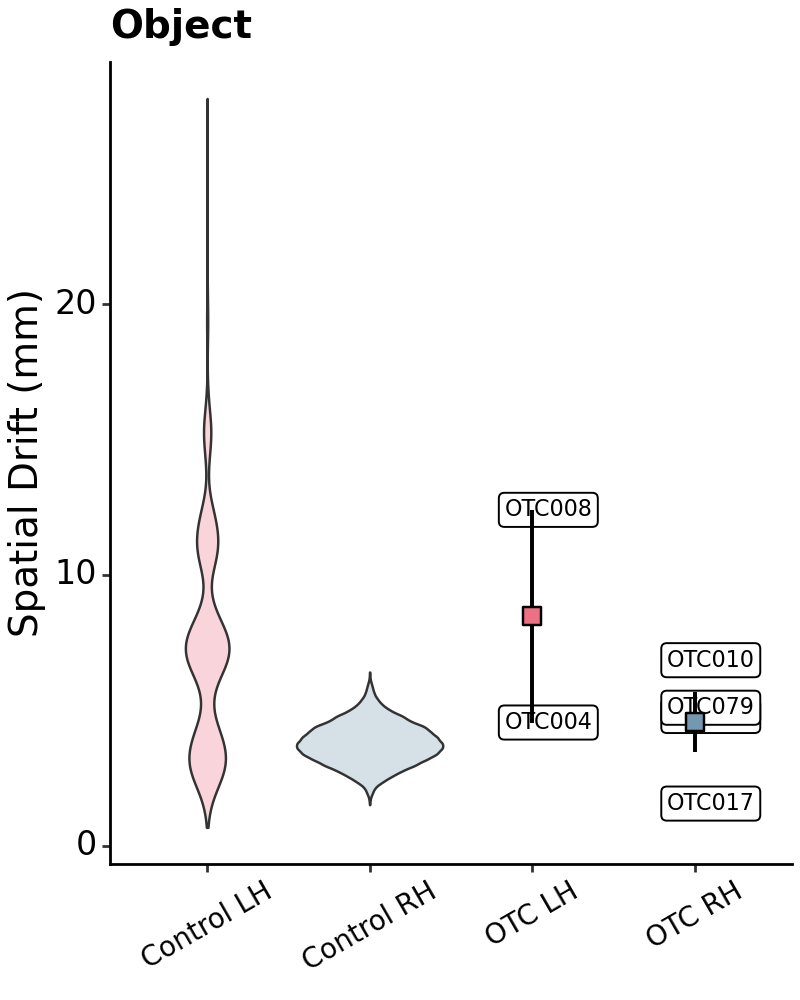



--- House ---


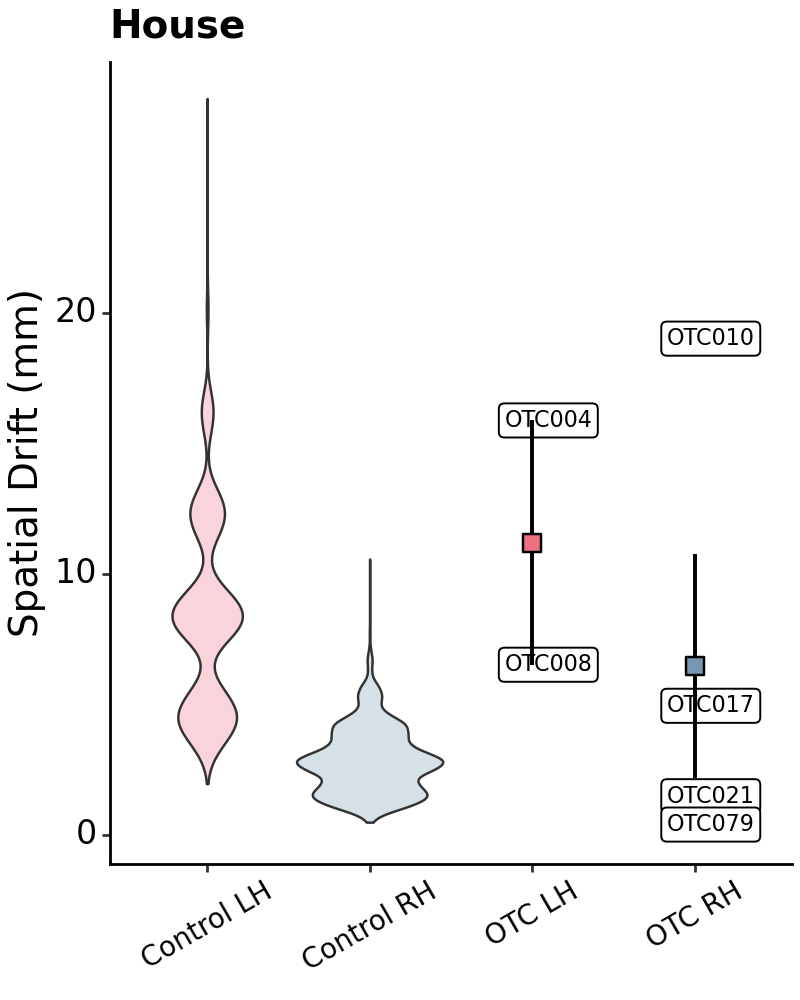



MDS SHIFT

--- Face ---


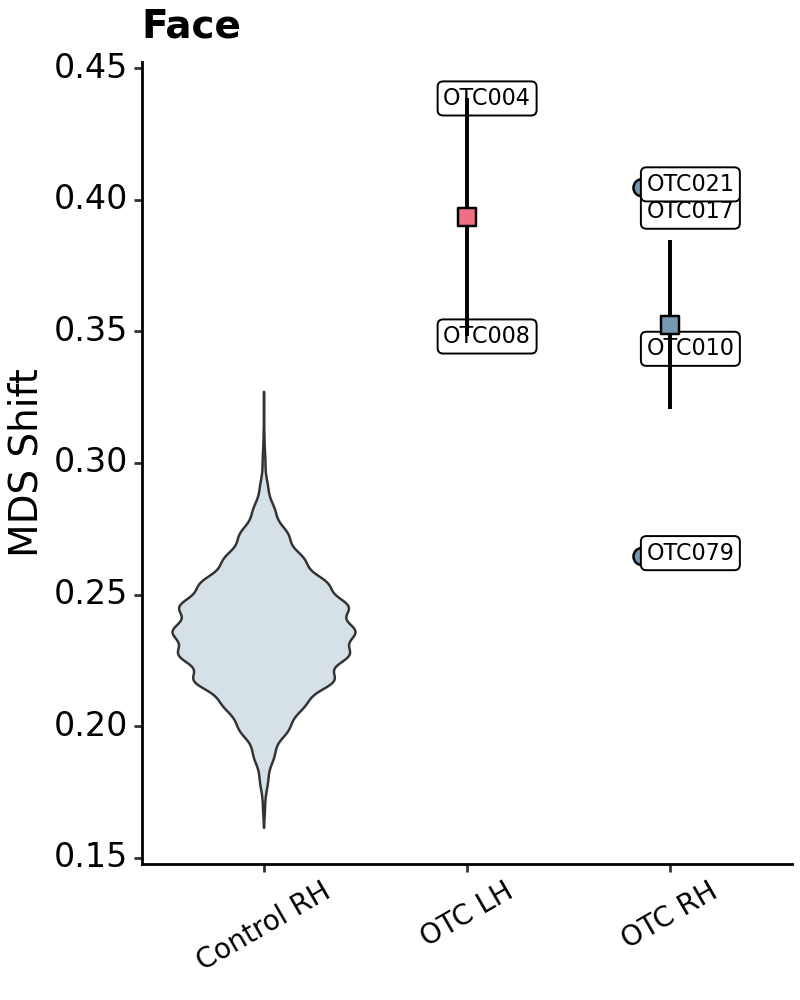



--- Word ---


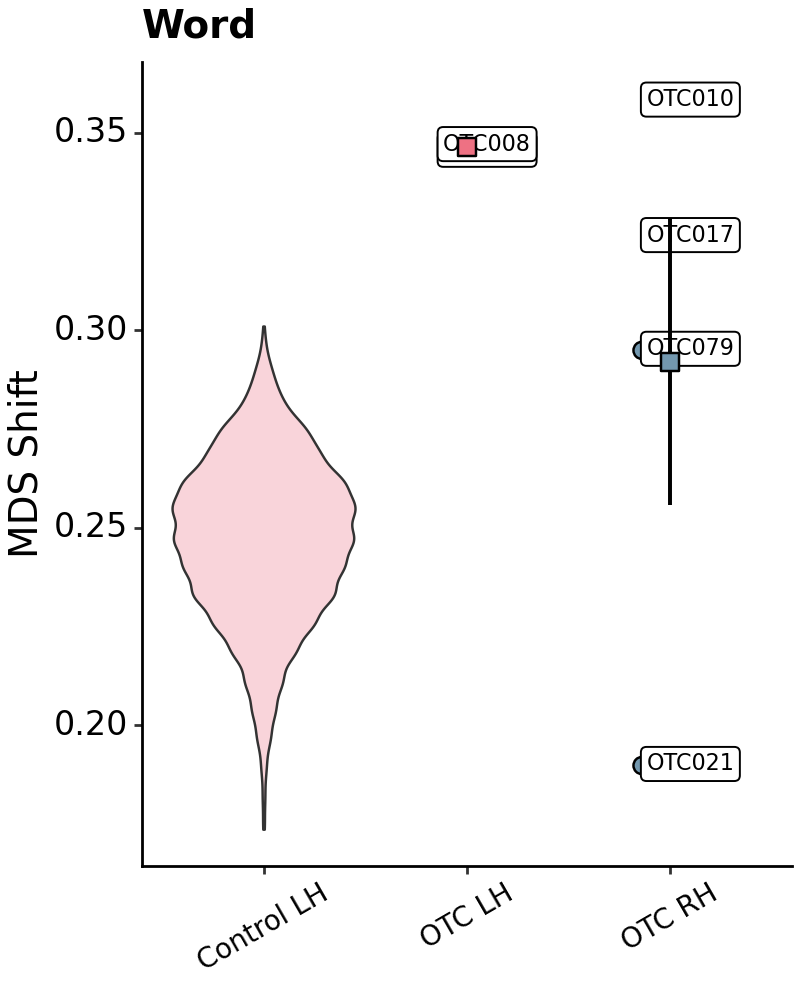



--- Object ---


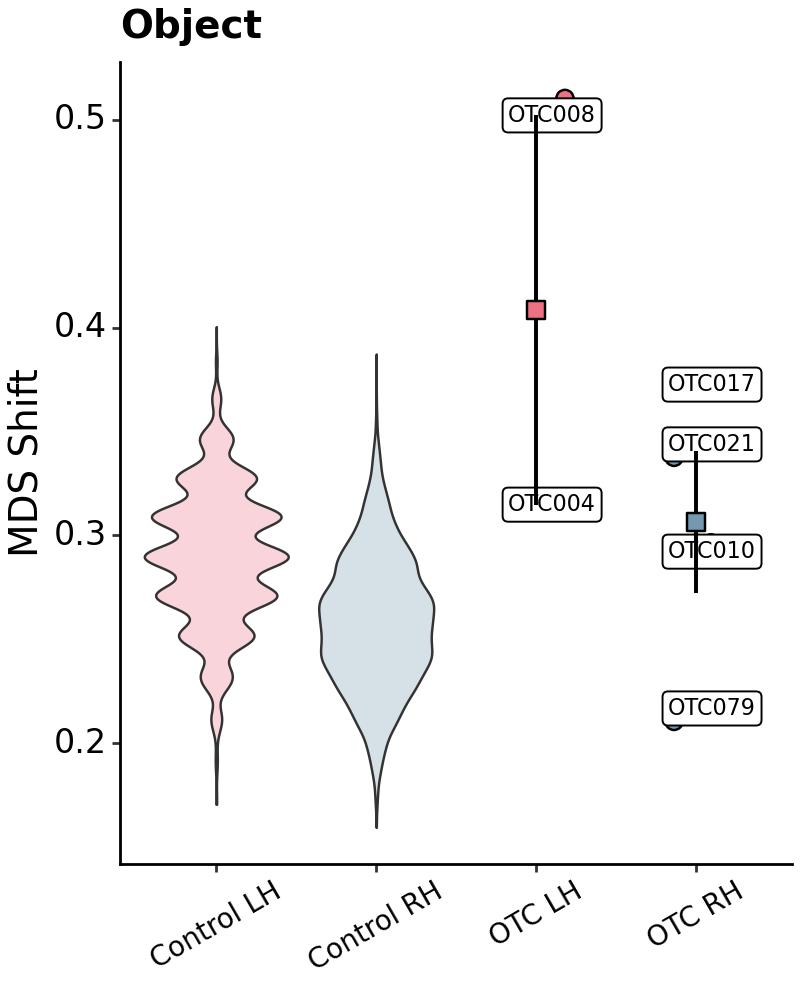



--- House ---


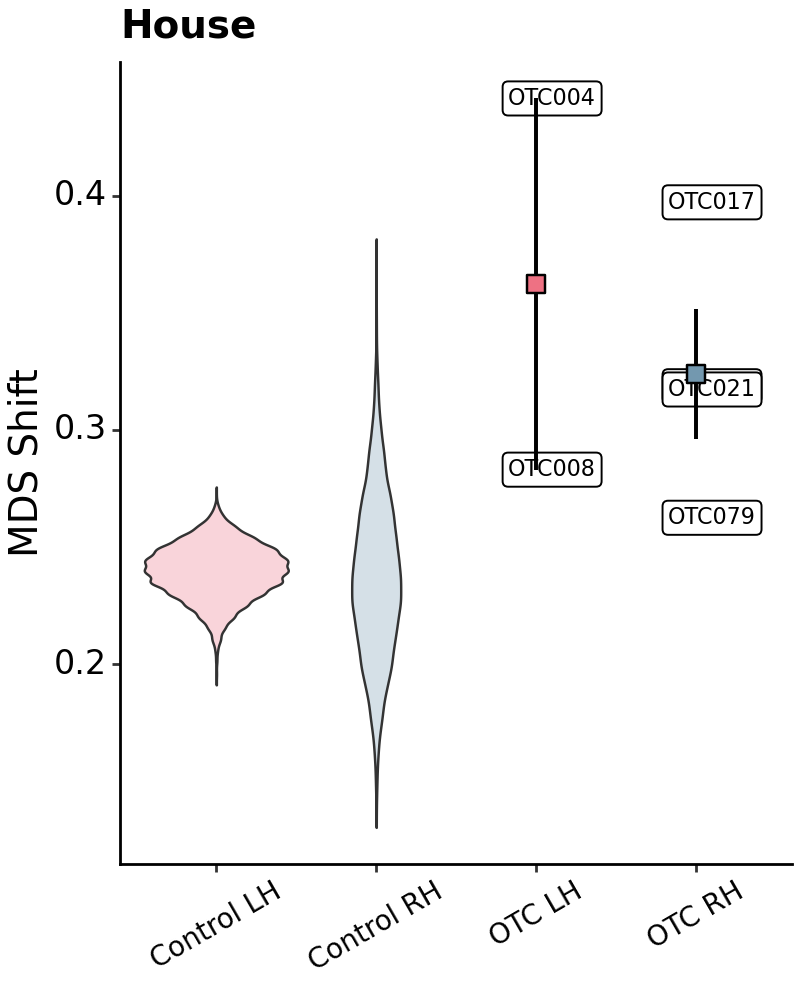



MEAN ACTIVATION CHANGE

--- Face ---


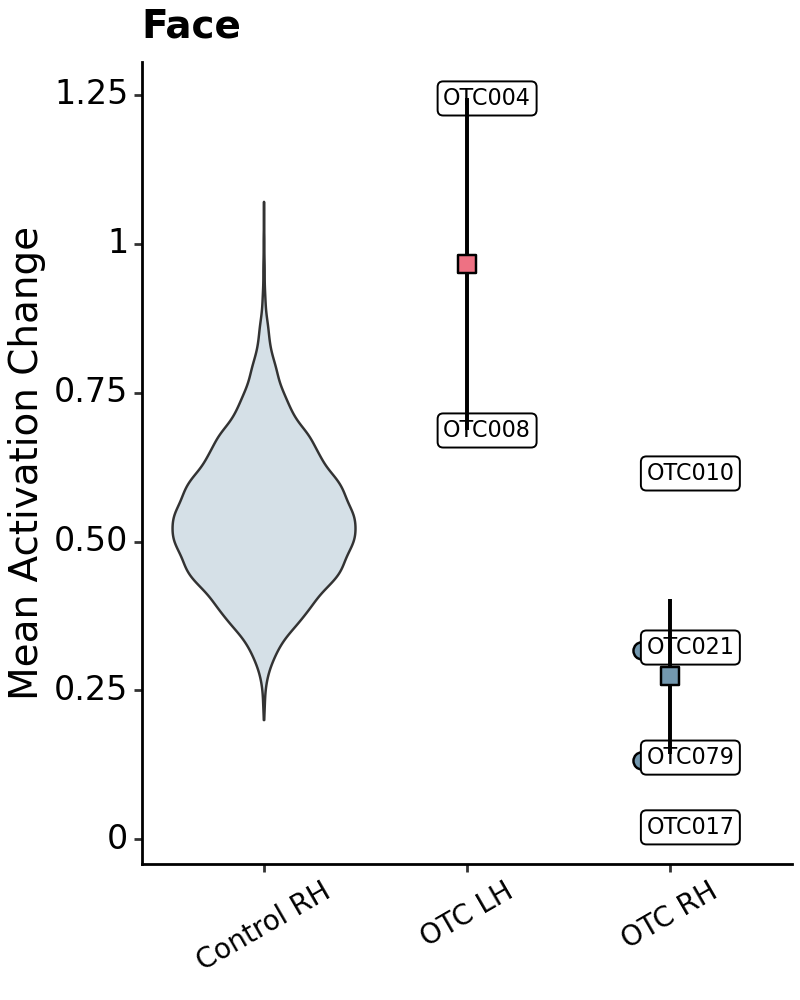



--- Word ---


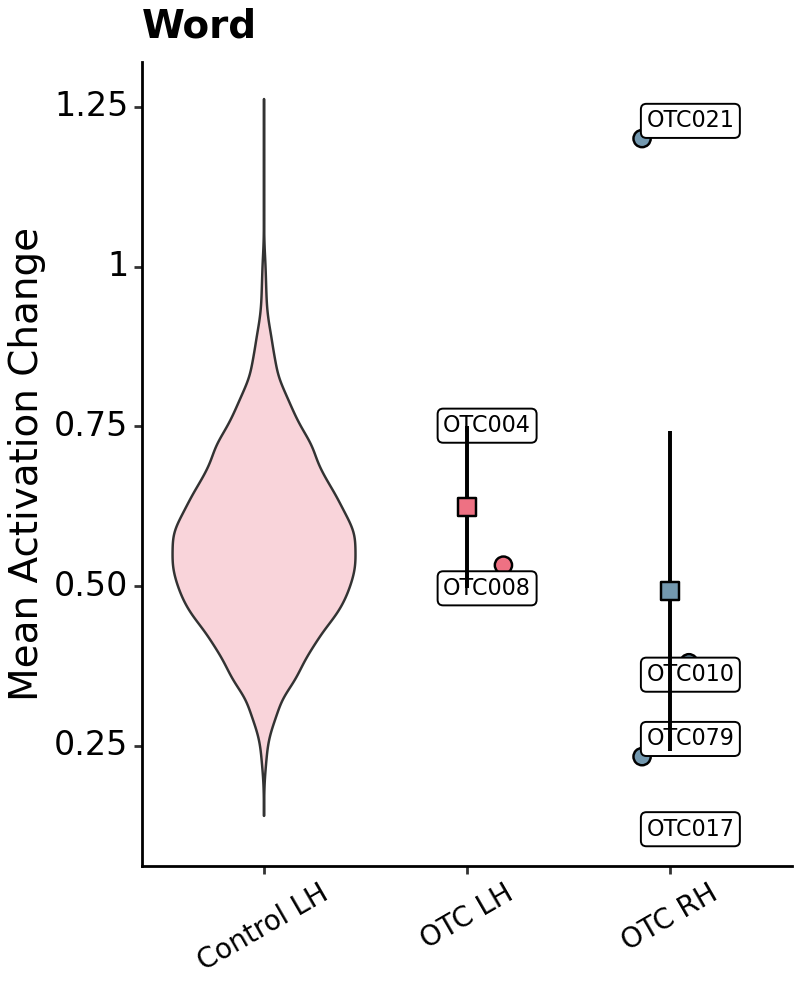



--- Object ---


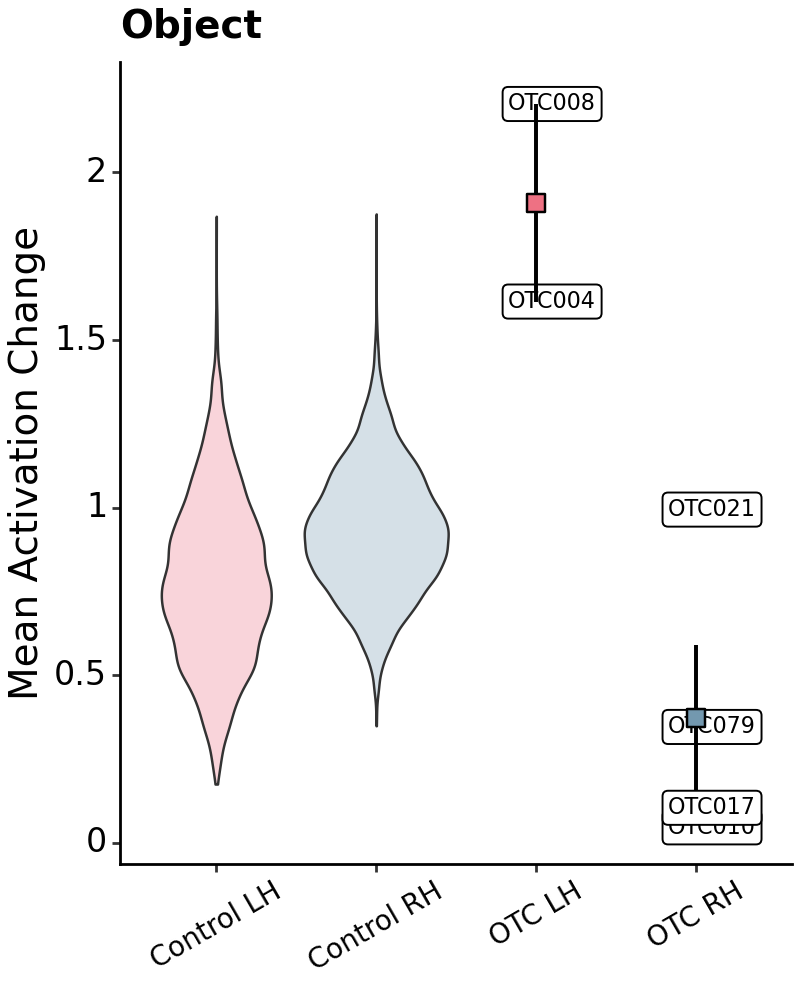



--- House ---


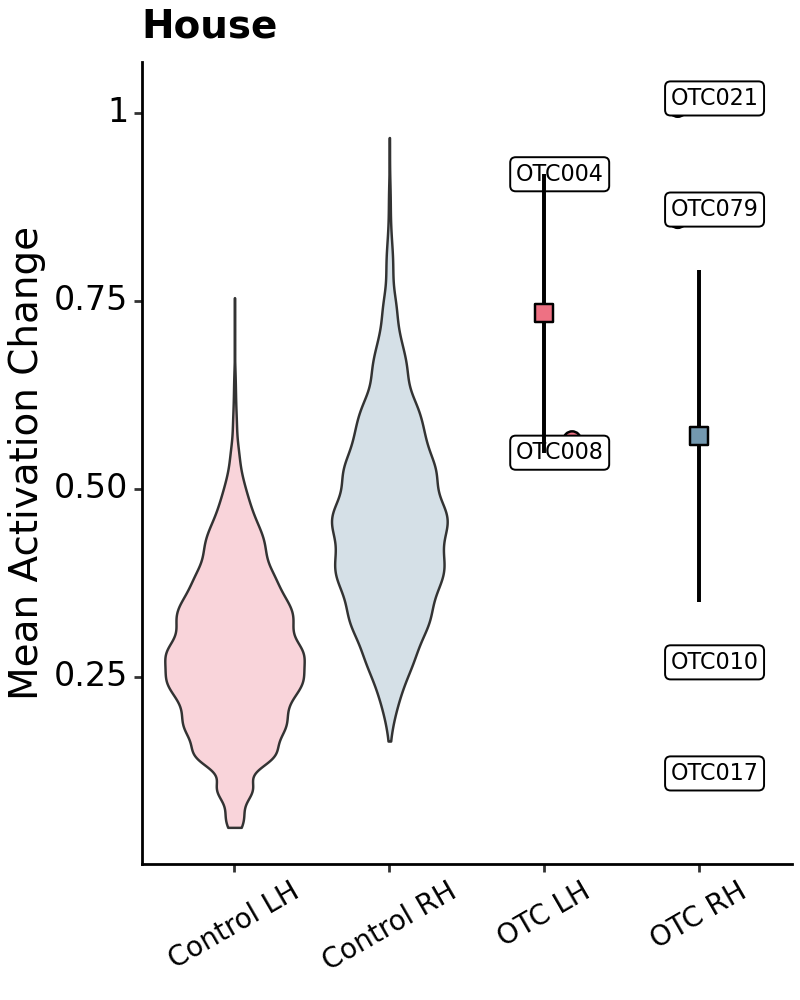



SUM SELECTIVITY CHANGE

--- Face ---


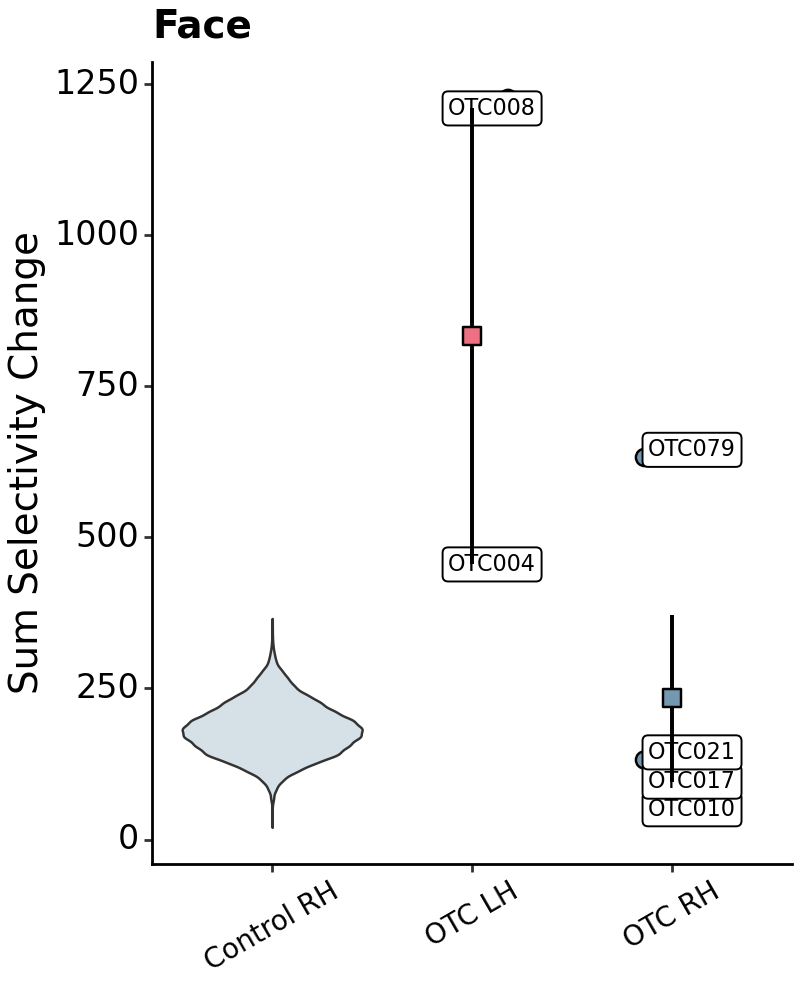



--- Word ---


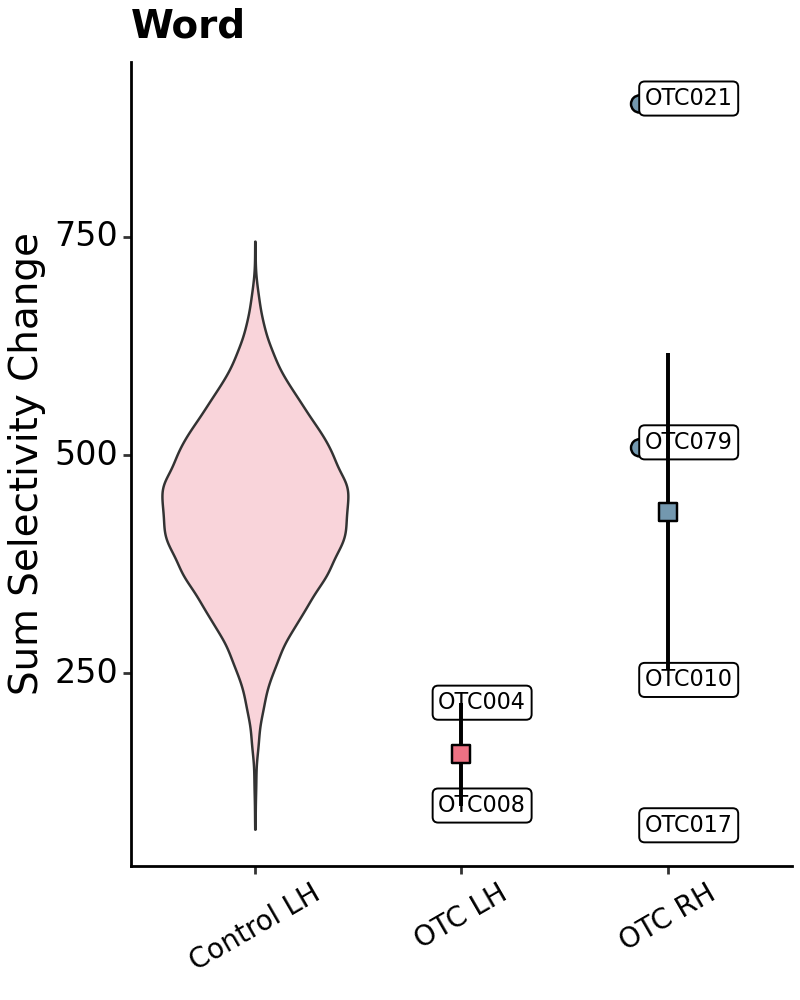



--- Object ---


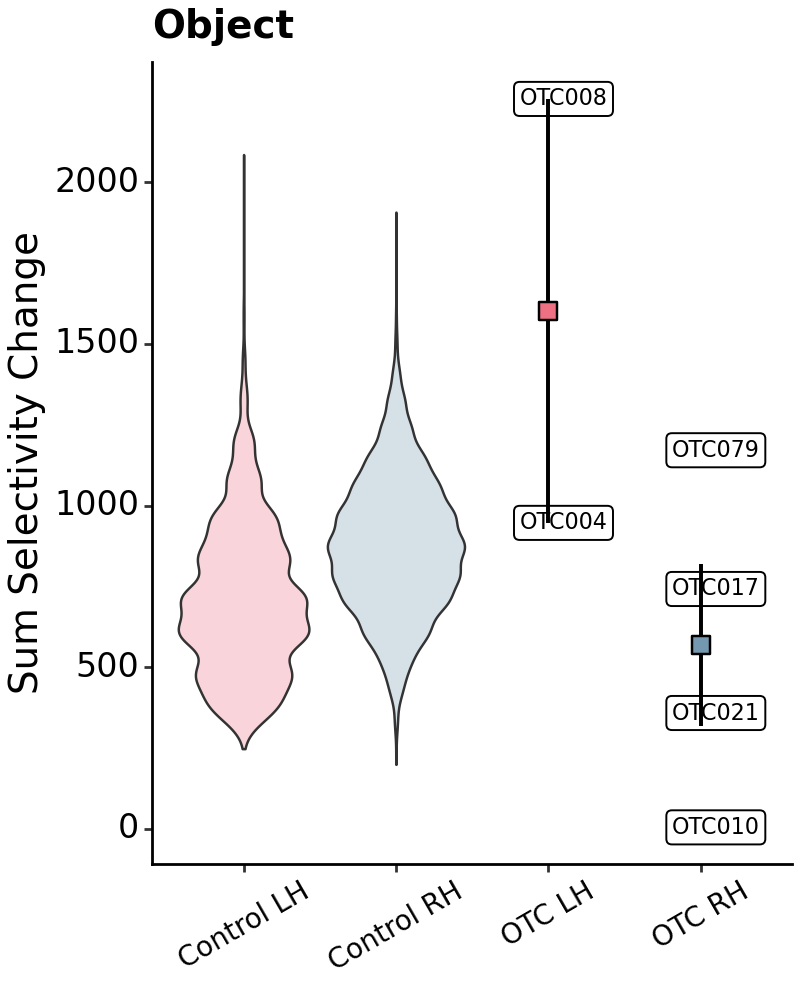



--- House ---


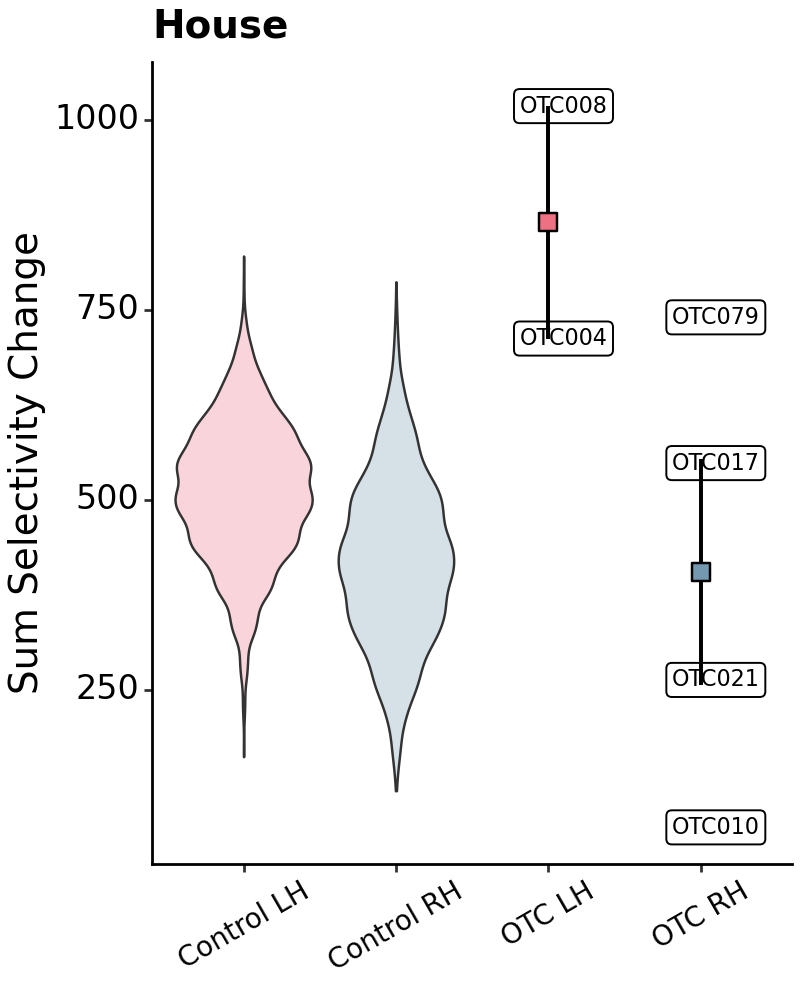



VISUALIZATIONS COMPLETE


In [23]:
## Cell 13: Visualization

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

# Color scheme following Ayzenberg
COLOR_LH = '#ee7183'  # pink for left hemisphere
COLOR_RH = '#7398af'  # blue for right hemisphere

def generate_bootstrap_resamples(data, value_col, n_boot=10000, seed=42):
    """Generate bootstrap resamples from control data"""
    np.random.seed(seed)
    values = data[value_col].dropna().values
    if len(values) == 0:
        return []
    resamples = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(values, size=len(values), replace=True)
        resamples.append(np.mean(boot_sample))
    return resamples


def create_single_plot(df, metric_col, metric_name, category, n_boot=10000, seed=42):
    """Create a single plot for one measure and one category"""
    
    # Filter to intact hemisphere
    filtered_df = filter_to_intact_hemisphere(df)
    
    # Get category data
    cat_data = filtered_df[filtered_df['category'] == category].copy()
    
    # Determine which control hemispheres to use based on category
    if category == 'word':
        control_hemis = ['l']  # Left-lateralized
    elif category == 'face':
        control_hemis = ['r']  # Right-lateralized
    else:  # object, house - bilateral
        control_hemis = ['l', 'r']
    
    # --- Prepare control resample data for violins ---
    resample_list = []
    for hemi in control_hemis:
        control_data = cat_data[(cat_data['group'] == 'control') & (cat_data['hemi'] == hemi)]
        if len(control_data) > 0:
            resamples = generate_bootstrap_resamples(control_data, metric_col, n_boot)
            hemi_label = 'LH' if hemi == 'l' else 'RH'
            for val in resamples:
                resample_list.append({
                    'x_group': f'Control {hemi_label}',
                    'value': val,
                    'hemi': hemi_label
                })
    
    resample_df = pd.DataFrame(resample_list)
    
    # --- Prepare OTC patient data for points ---
    otc_data = cat_data[cat_data['group'] == 'OTC'].copy()
    if len(otc_data) > 0:
        otc_data['hemi_label'] = otc_data['hemi'].apply(lambda x: 'LH' if x == 'l' else 'RH')
        otc_data['x_group'] = 'OTC ' + otc_data['hemi_label']
        otc_data['value'] = otc_data[metric_col]
        patient_df = otc_data[['code', 'x_group', 'value', 'hemi_label']].copy()
        patient_df = patient_df.rename(columns={'hemi_label': 'hemi'})
        patient_df = patient_df.dropna(subset=['value'])
    else:
        patient_df = pd.DataFrame(columns=['code', 'x_group', 'value', 'hemi'])
    
    # --- Prepare mean/SE for OTC groups ---
    mean_list = []
    for hemi in ['l', 'r']:
        hemi_data = otc_data[otc_data['hemi'] == hemi] if len(otc_data) > 0 else pd.DataFrame()
        if len(hemi_data) > 0:
            hemi_label = 'LH' if hemi == 'l' else 'RH'
            vals = hemi_data[metric_col].dropna()
            if len(vals) > 0:
                mean_list.append({
                    'x_group': f'OTC {hemi_label}',
                    'value': vals.mean(),
                    'se': vals.sem() if len(vals) > 1 else 0,
                    'hemi': hemi_label
                })
    
    mean_df = pd.DataFrame(mean_list)
    
    # Set x_group order
    if category == 'word':
        x_order = ['Control LH', 'OTC LH', 'OTC RH']
    elif category == 'face':
        x_order = ['Control RH', 'OTC LH', 'OTC RH']
    else:  # bilateral
        x_order = ['Control LH', 'Control RH', 'OTC LH', 'OTC RH']
    
    # Filter x_order to only include groups that exist in the data
    existing_groups = set(resample_df['x_group'].unique()) | set(patient_df['x_group'].unique())
    x_order = [x for x in x_order if x in existing_groups]
    
    # Convert x_group to categorical with order
    if len(resample_df) > 0:
        resample_df['x_group'] = pd.Categorical(resample_df['x_group'], categories=x_order, ordered=True)
    if len(patient_df) > 0:
        patient_df['x_group'] = pd.Categorical(patient_df['x_group'], categories=x_order, ordered=True)
    if len(mean_df) > 0:
        mean_df['x_group'] = pd.Categorical(mean_df['x_group'], categories=x_order, ordered=True)
    
    # Build plot
    p = ggplot()
    
    # Add violin for control resamples
    if len(resample_df) > 0:
        p = p + geom_violin(resample_df, aes(x='x_group', y='value', fill='hemi'), alpha=0.3)
    
    # Add jittered points for OTC patients
    if len(patient_df) > 0:
        p = p + geom_jitter(patient_df, aes(x='x_group', y='value', fill='hemi'),
                           shape='o', size=3, width=0.2, random_state=seed)
        p = p + geom_label(patient_df, aes(x='x_group', y='value', label='code'),
                          size=8, nudge_x=0.1)
    
    # Add mean +/- SE for OTC groups
    if len(mean_df) > 0:
        p = p + geom_pointrange(mean_df, aes(x='x_group', y='value', 
                                              ymin='value - se', ymax='value + se', fill='hemi'),
                                shape='s', size=0.8)
    
    # Styling
    p = (p
         + scale_fill_manual(values={'LH': COLOR_LH, 'RH': COLOR_RH})
         + labs(x='', y=metric_name, title=f'{category.title()}')
         + theme_classic()
         + theme(
             text=element_text(color='black'),
             axis_text_x=element_text(angle=30, size=10),
             axis_text_y=element_text(size=12),
             axis_title=element_text(size=14),
             plot_title=element_text(size=14, weight='bold'),
             legend_position='none',
             figure_size=(4, 5)
         )
    )
    
    return p


# --- Generate all plots ---

print("="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Prepare MDS data with code column
mds_plot_df = mds_df.groupby(['subject', 'group', 'hemi', 'measured_category'])['mds_shift'].mean().reset_index()
mds_plot_df = mds_plot_df.rename(columns={'measured_category': 'category'})
for sid in mds_plot_df['subject'].unique():
    if sid in SUBJECTS:
        mds_plot_df.loc[mds_plot_df['subject'] == sid, 'code'] = SUBJECTS[sid]['code']

# Define measures to plot
measures = [
    (selectivity_df, 'selectivity_change', 'Selectivity Change'),
    (geometry_df, 'geometry_preservation', 'Geometry Preservation'),
    (drift_df, 'spatial_drift_mm', 'Spatial Drift (mm)'),
    (mds_plot_df, 'mds_shift', 'MDS Shift'),
    (ayzenberg_df, 'mean_activation_change', 'Mean Activation Change'),
    (ayzenberg_df, 'sum_selectivity_change', 'Sum Selectivity Change'),
]

categories = ['face', 'word', 'object', 'house']

# Generate individual plots
for df, metric_col, metric_name in measures:
    print(f"\n{'='*70}")
    print(f"{metric_name.upper()}")
    print("="*70)
    
    for cat in categories:
        print(f"\n--- {cat.title()} ---")
        try:
            p = create_single_plot(df, metric_col, metric_name, cat)
            print(p)
        except Exception as e:
            print(f"Error creating plot: {e}")

print("\n" + "="*70)
print("VISUALIZATIONS COMPLETE")
print("="*70)

In [1]:
## Cell 13: Visualization

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

# Color scheme following Ayzenberg
COLOR_LH = '#ee7183'  # pink for left hemisphere
COLOR_RH = '#7398af'  # blue for right hemisphere

def generate_bootstrap_resamples(data, value_col, n_boot=10000, seed=42):
    """Generate bootstrap resamples from control data"""
    np.random.seed(seed)
    values = data[value_col].dropna().values
    if len(values) == 0:
        return []
    resamples = []
    for _ in range(n_boot):
        boot_sample = np.random.choice(values, size=len(values), replace=True)
        resamples.append(np.mean(boot_sample))
    return resamples


def compute_axis_range(df, metric_col, categories, padding=0.1):
    """Compute consistent y-axis range across all categories for a metric"""
    all_values = []
    
    filtered_df = filter_to_intact_hemisphere(df)
    
    for category in categories:
        cat_data = filtered_df[filtered_df['category'] == category]
        values = cat_data[metric_col].dropna().values
        if len(values) > 0:
            all_values.extend(values)
    
    if len(all_values) == 0:
        return (0, 1)
    
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    range_val = max_val - min_val
    
    # Add padding
    y_min = min_val - padding * range_val
    y_max = max_val + padding * range_val
    
    return (y_min, y_max)


def create_single_plot(df, metric_col, metric_name, category, y_limits=None, n_boot=10000, seed=42):
    """Create a single plot for one measure and one category"""
    
    # Filter to intact hemisphere
    filtered_df = filter_to_intact_hemisphere(df)
    
    # Get category data
    cat_data = filtered_df[filtered_df['category'] == category].copy()
    
    # Determine which control hemispheres to use based on category
    if category == 'word':
        control_hemis = ['l']  # Left-lateralized
    elif category == 'face':
        control_hemis = ['r']  # Right-lateralized
    else:  # object, house - bilateral
        control_hemis = ['l', 'r']
    
    # --- Prepare control resample data for violins ---
    resample_list = []
    for hemi in control_hemis:
        control_data = cat_data[(cat_data['group'] == 'control') & (cat_data['hemi'] == hemi)]
        if len(control_data) > 0:
            resamples = generate_bootstrap_resamples(control_data, metric_col, n_boot)
            hemi_label = 'LH' if hemi == 'l' else 'RH'
            for val in resamples:
                resample_list.append({
                    'x_group': f'Control {hemi_label}',
                    'value': val,
                    'hemi': hemi_label
                })
    
    resample_df = pd.DataFrame(resample_list)
    
    # --- Prepare OTC patient data for points ---
    otc_data = cat_data[cat_data['group'] == 'OTC'].copy()
    if len(otc_data) > 0:
        otc_data['hemi_label'] = otc_data['hemi'].apply(lambda x: 'LH' if x == 'l' else 'RH')
        otc_data['x_group'] = 'OTC ' + otc_data['hemi_label']
        otc_data['value'] = otc_data[metric_col]
        patient_df = otc_data[['code', 'x_group', 'value', 'hemi_label']].copy()
        patient_df = patient_df.rename(columns={'hemi_label': 'hemi'})
        patient_df = patient_df.dropna(subset=['value'])
    else:
        patient_df = pd.DataFrame(columns=['code', 'x_group', 'value', 'hemi'])
    
    # --- Prepare mean/SE for OTC groups ---
    mean_list = []
    for hemi in ['l', 'r']:
        hemi_data = otc_data[otc_data['hemi'] == hemi] if len(otc_data) > 0 else pd.DataFrame()
        if len(hemi_data) > 0:
            hemi_label = 'LH' if hemi == 'l' else 'RH'
            vals = hemi_data[metric_col].dropna()
            if len(vals) > 0:
                mean_list.append({
                    'x_group': f'OTC {hemi_label}',
                    'value': vals.mean(),
                    'se': vals.sem() if len(vals) > 1 else 0,
                    'hemi': hemi_label
                })
    
    mean_df = pd.DataFrame(mean_list)
    
    # Set x_group order
    if category == 'word':
        x_order = ['Control LH', 'OTC LH', 'OTC RH']
    elif category == 'face':
        x_order = ['Control RH', 'OTC LH', 'OTC RH']
    else:  # bilateral
        x_order = ['Control LH', 'Control RH', 'OTC LH', 'OTC RH']
    
    # Filter x_order to only include groups that exist in the data
    existing_groups = set(resample_df['x_group'].unique()) | set(patient_df['x_group'].unique())
    x_order = [x for x in x_order if x in existing_groups]
    
    # Convert x_group to categorical with order
    if len(resample_df) > 0:
        resample_df['x_group'] = pd.Categorical(resample_df['x_group'], categories=x_order, ordered=True)
    if len(patient_df) > 0:
        patient_df['x_group'] = pd.Categorical(patient_df['x_group'], categories=x_order, ordered=True)
    if len(mean_df) > 0:
        mean_df['x_group'] = pd.Categorical(mean_df['x_group'], categories=x_order, ordered=True)
    
    # Build plot
    p = ggplot()
    
    # Add violin for control resamples (using default smoothing)
    if len(resample_df) > 0:
        p = p + geom_violin(resample_df, aes(x='x_group', y='value', fill='hemi'), alpha=0.3)
    
    # Add jittered points for OTC patients
    if len(patient_df) > 0:
        p = p + geom_jitter(patient_df, aes(x='x_group', y='value', fill='hemi'),
                           shape='o', size=3, width=0.2, random_state=seed)
        p = p + geom_label(patient_df, aes(x='x_group', y='value', label='code'),
                          size=8, nudge_x=0.1)
    
    # Add mean +/- SE for OTC groups
    if len(mean_df) > 0:
        p = p + geom_pointrange(mean_df, aes(x='x_group', y='value', 
                                              ymin='value - se', ymax='value + se', fill='hemi'),
                                shape='s', size=0.8)
    
    # Styling
    p = (p
         + scale_fill_manual(values={'LH': COLOR_LH, 'RH': COLOR_RH})
         + labs(x='', y=metric_name, title=f'{category.title()}')
         + theme_classic()
         + theme(
             text=element_text(color='black'),
             axis_text_x=element_text(angle=30, size=10),
             axis_text_y=element_text(size=12),
             axis_title=element_text(size=14),
             plot_title=element_text(size=14, weight='bold'),
             legend_position='none',
             figure_size=(4, 5)
         )
    )
    
    # Apply consistent y-axis limits if provided
    if y_limits is not None:
        p = p + ylim(y_limits[0], y_limits[1])
    
    return p


# --- Generate all plots ---

print("="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Prepare MDS data with code column
mds_plot_df = mds_df.groupby(['subject', 'group', 'hemi', 'measured_category'])['mds_shift'].mean().reset_index()
mds_plot_df = mds_plot_df.rename(columns={'measured_category': 'category'})
for sid in mds_plot_df['subject'].unique():
    if sid in SUBJECTS:
        mds_plot_df.loc[mds_plot_df['subject'] == sid, 'code'] = SUBJECTS[sid]['code']

# Define measures to plot (renamed selectivity_change to Distinctiveness)
measures = [
    (selectivity_df, 'selectivity_change', 'Distinctiveness'),
    (geometry_df, 'geometry_preservation', 'Geometry Preservation'),
    (drift_df, 'spatial_drift_mm', 'Spatial Drift (mm)'),
    (mds_plot_df, 'mds_shift', 'MDS Shift'),
    (ayzenberg_df, 'mean_activation_change', 'Mean Activation Change'),
    (ayzenberg_df, 'sum_selectivity_change', 'Sum Selectivity Change'),
]

categories = ['face', 'word', 'object', 'house']

# Generate individual plots with consistent axes per metric
for df, metric_col, metric_name in measures:
    print(f"\n{'='*70}")
    print(f"{metric_name.upper()}")
    print("="*70)
    
    # Compute consistent y-axis range for this metric across all categories
    y_limits = compute_axis_range(df, metric_col, categories)
    print(f"Y-axis range: {y_limits[0]:.3f} to {y_limits[1]:.3f}")
    
    for cat in categories:
        print(f"\n--- {cat.title()} ---")
        try:
            p = create_single_plot(df, metric_col, metric_name, cat, y_limits=y_limits)
            print(p)
        except Exception as e:
            print(f"Error creating plot: {e}")

print("\n" + "="*70)
print("VISUALIZATIONS COMPLETE")
print("="*70)

GENERATING VISUALIZATIONS


NameError: name 'mds_df' is not defined